In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

successfully loaded {'experiment_name': 'fvt_training_higher_sr', 'n_sample_ratio': 1.0, 'signal_ratio': 0.01, 'seed': 42}


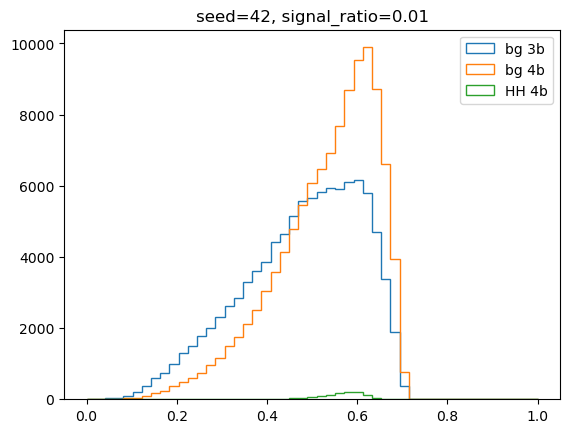

successfully loaded {'experiment_name': 'fvt_training_higher_sr', 'n_sample_ratio': 1.0, 'signal_ratio': 0.02, 'seed': 42}


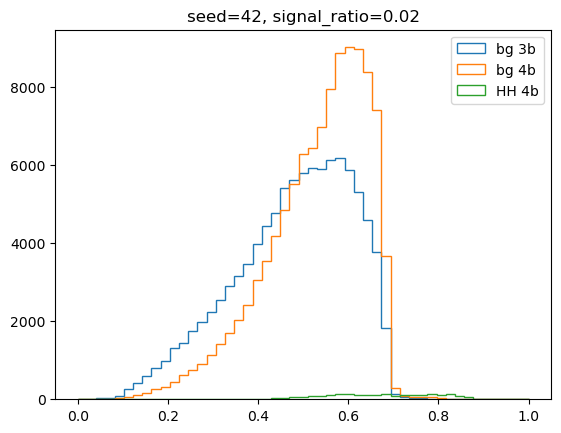

successfully loaded {'experiment_name': 'fvt_training_higher_sr', 'n_sample_ratio': 1.0, 'signal_ratio': 0.03, 'seed': 42}


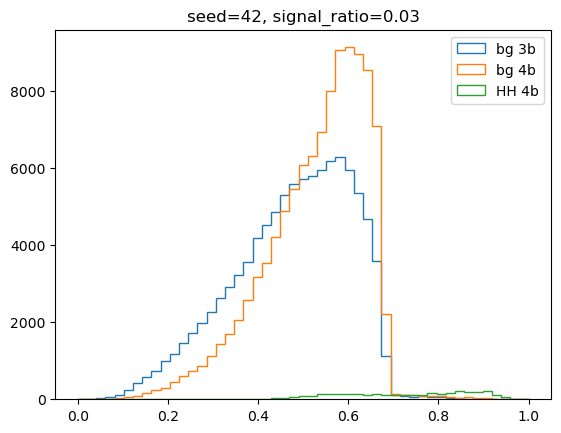

successfully loaded {'experiment_name': 'fvt_training_higher_sr', 'n_sample_ratio': 1.0, 'signal_ratio': 0.04, 'seed': 42}


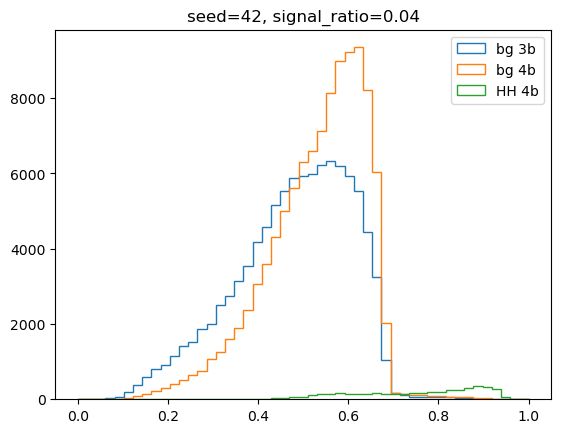

successfully loaded {'experiment_name': 'fvt_training_higher_sr', 'n_sample_ratio': 1.0, 'signal_ratio': 0.05, 'seed': 42}


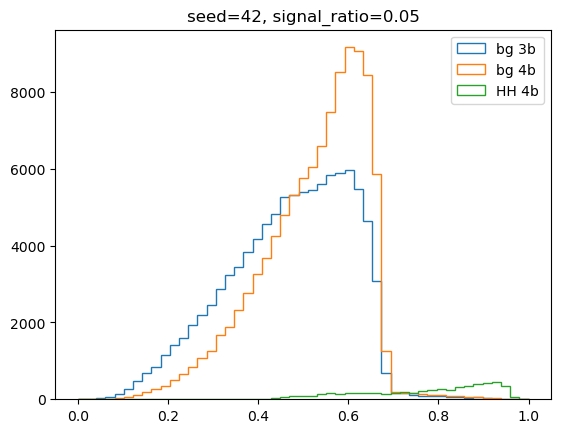

In [3]:
import torch
from dataset import generate_tt_dataset
from training_info import TrainingInfo
import pytorch_lightning as pl
import yaml
from fvt_classifier import FvTClassifier
from code_fragments import att_q_repr_hist, fvt_score_hist
from events_data import EventsData
import tqdm
import numpy as np
import matplotlib.pyplot as plt

config_filename = "configs/fvt_training_higher_sr.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
n_all4b = config["n_all4b"]
signal_ratio = config["signal_ratio"]
test_ratio = config["test_ratio"]
# n_sample_ratios = config["n_sample_ratios"]
n_sample_ratios = [1.0]
seeds = [42]
w_cuts = np.arange(0.01, 1.01, 0.01)
signal_ratios = [0.01, 0.02, 0.03, 0.04, 0.05]

fvt_scores_dict = {seed: {} for seed in seeds}
att_q_reprs_dict = {seed: {} for seed in seeds}
events_test_dict = {seed: {} for seed in seeds}
is_in_regions_list_dict = {seed: {} for seed in seeds}
embeddings_dict = {seed: {} for seed in seeds}

for seed in seeds:
    for signal_ratio in signal_ratios:
        _, dinfo_test = generate_tt_dataset(
                seed,
                n_3b,
                n_all4b,
                signal_ratio,
                test_ratio,
            )
        events_test = EventsData.from_dataframe(dinfo_test.fetch_data(), features)
        hparam_filter = {
            "experiment_name": experiment_name, 
            "n_sample_ratio": 1.0, 
            "signal_ratio": signal_ratio, 
            "seed": seed
        }
        hashes = TrainingInfo.find(hparam_filter)
        assert len(hashes) == 1
        print("successfully loaded", hparam_filter)
        hash = hashes[0]
        tinfo = TrainingInfo.load(hash)

        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_test.set_model_scores(fvt_model)
        
        events_test_dict[seed][signal_ratio] = events_test.clone()
        fvt_scores_dict[seed][signal_ratio] = events_test.fvt_score.copy()
        att_q_reprs_dict[seed][signal_ratio] = events_test.att_q_repr.copy()

        fig, ax = plt.subplots()
        bins_range = np.linspace(0, 1, 50)
        ax.set_title(f"seed={seed}, signal_ratio={signal_ratio}")
        ax.hist(fvt_scores_dict[seed][signal_ratio][events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax.hist(fvt_scores_dict[seed][signal_ratio][events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax.hist(fvt_scores_dict[seed][signal_ratio][events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax.legend()

        plt.show()
        plt.close()

/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Elapsed time: 0.11 s
Elapsed time: 7.00 s
Elapsed time: 0.94 s


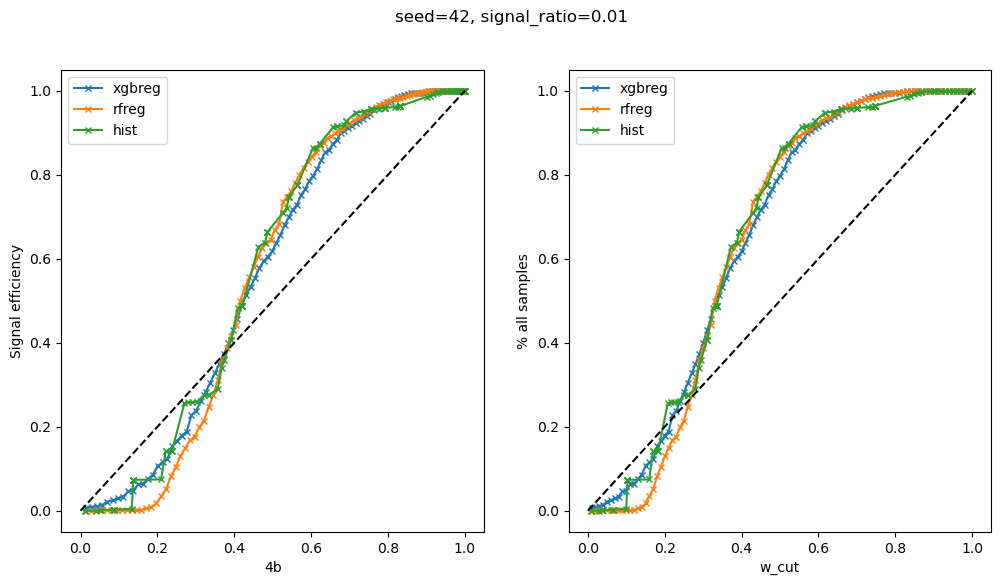

Elapsed time: 0.11 s
Elapsed time: 7.54 s
Elapsed time: 0.81 s


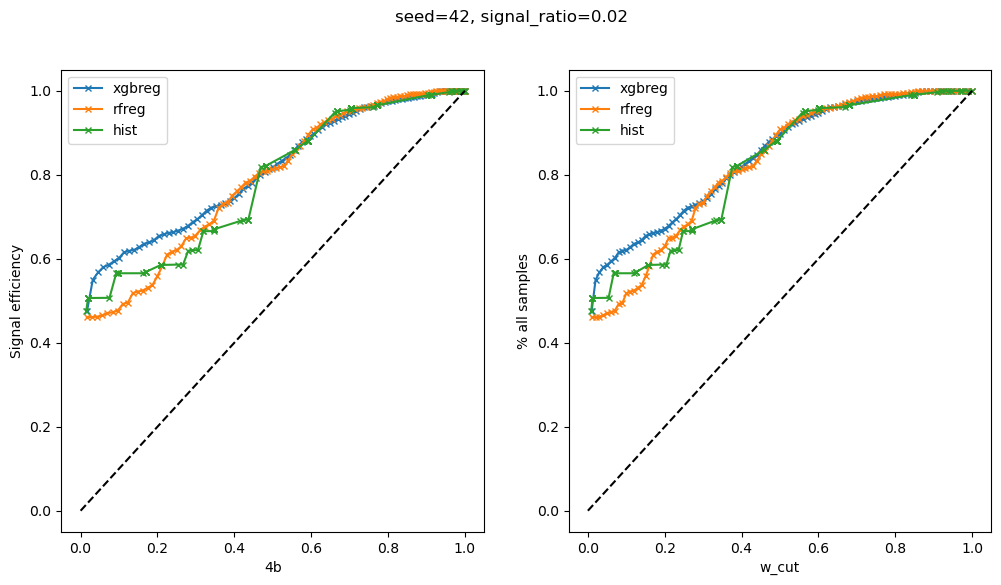

Elapsed time: 0.13 s
Elapsed time: 6.78 s
Elapsed time: 0.93 s


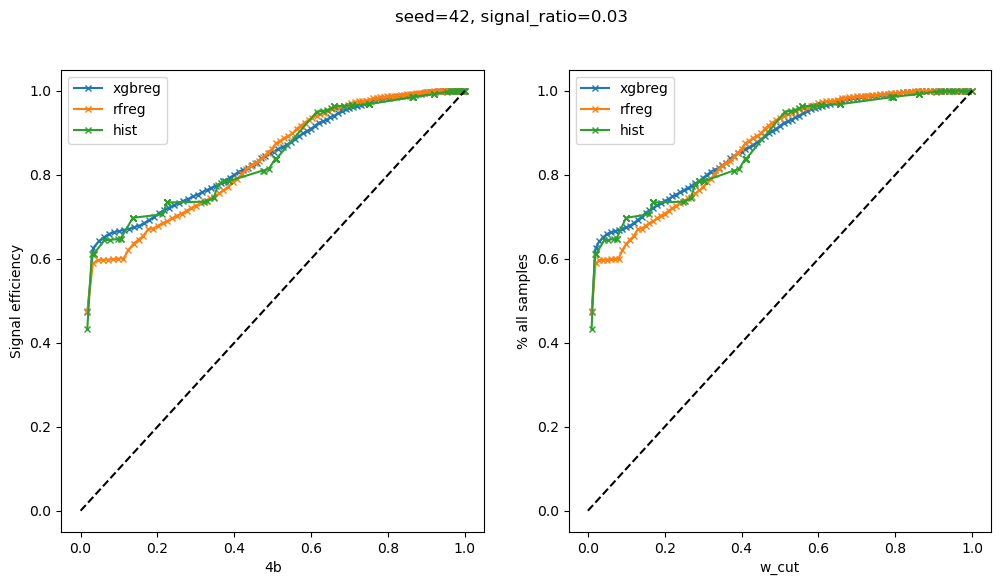

Elapsed time: 0.10 s
Elapsed time: 6.68 s
Elapsed time: 1.67 s


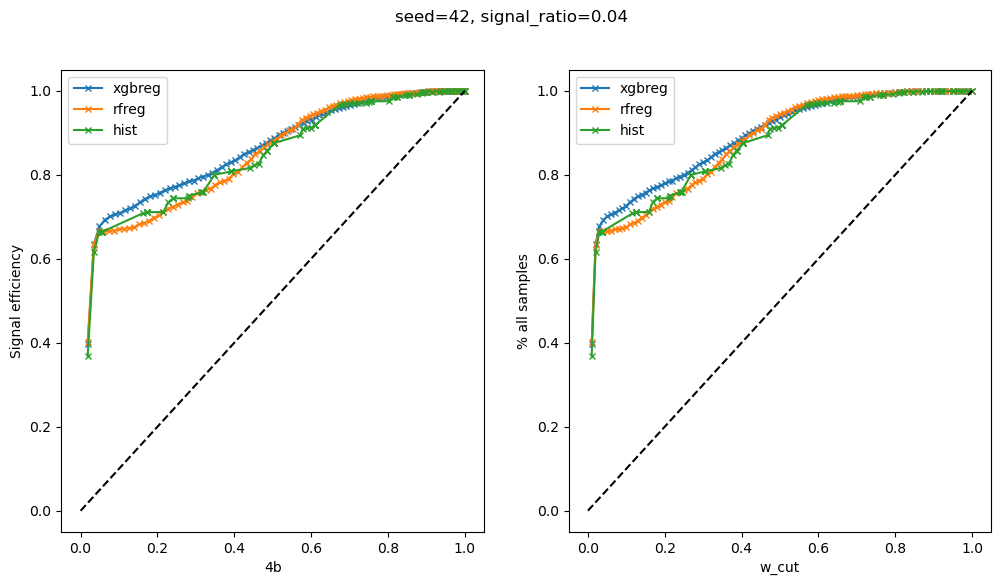

Elapsed time: 0.10 s
Elapsed time: 6.67 s
Elapsed time: 1.41 s


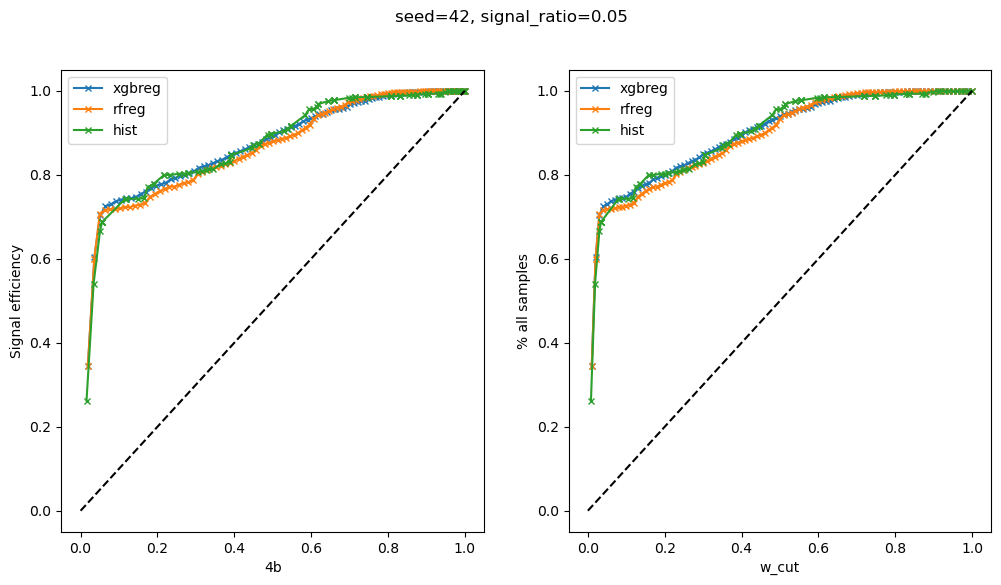

In [4]:
import time
from signal_region import get_regions_via_histogram, get_regions_via_probs_4b
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

using_features = [0, 1, 2, 3, 4, 5]
w_cuts = np.arange(0.01, 1.01, 0.01)

for seed in seeds:
    for signal_ratio in signal_ratios:
        events = events_test_dict[seed][signal_ratio]
        is_3b = events.is_3b
        is_bg4b = events.is_bg4b
        is_signal = events.is_signal
        is_4b = events.is_4b
        w = events.weights

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle(f"seed={seed}, signal_ratio={signal_ratio}")

        att_q_repr = att_q_reprs_dict[seed][signal_ratio]

        for method in ["xgbreg", "rfreg", "hist"]:
            start_time = time.time()
            if method == "xgbreg":
                xgbreg = XGBRegressor(n_estimators=20, max_depth=5, random_state=seed)
                xgbreg.fit(att_q_repr, is_4b, sample_weight=w)
                probs_4b_estimated = xgbreg.predict(att_q_repr)
                is_in_regions_list = get_regions_via_probs_4b(events, w_cuts, probs_4b_estimated)
            elif method == "rfreg":
                rfreg = RandomForestRegressor(n_estimators=20, max_depth=5, random_state=seed)
                rfreg.fit(att_q_repr, is_4b, sample_weight=w)
                probs_4b_estimated = rfreg.predict(att_q_repr)
                is_in_regions_list = get_regions_via_probs_4b(events, w_cuts, probs_4b_estimated)
            elif method == "hist":
                is_in_regions_list = get_regions_via_histogram(events, w_cuts, n_bins=8)
            else:
                raise ValueError(f"Unknown method: {method}")

            print(f"Elapsed time: {time.time() - start_time:.2f} s")

            w_signal = np.array([np.sum(w[is_signal & is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w[is_signal])
            w_all = np.array([np.sum(w[is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w)
            w_4b = np.array([np.sum(w[is_4b & is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w[is_4b])

            ax[0].plot( 
                w_4b,
                w_signal,
                label=method,
                marker="x",
                markersize=4
            )
            ax[1].plot(
                w_all,
                w_signal,
                label=method,
                marker="x",
                markersize=4
            )

        ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")
        ax[0].set_xlabel("4b")
        ax[0].set_ylabel("Signal efficiency")
        ax[0].legend()

        ax[1].plot([0, 1], [0, 1], linestyle="--", color="black")
        ax[1].set_xlabel("w_cut")
        ax[1].set_ylabel("% all samples")
        ax[1].legend()

        plt.show()
        plt.close()


In [5]:
# XGB hyparams tuning

import pandas as pd
from itertools import product
import cupy as cp

using_features = [0, 1, 2, 3, 4, 5]
w_cuts = np.arange(0.01, 1.01, 0.01)

max_depths = [2, 5, 10, 20]
n_estimators = [10, 20, 50, 100]

performance_dict = {(seed, signal_ratio): {} for seed in seeds for signal_ratio in signal_ratios}

for seed in seeds:
    for signal_ratio in signal_ratios:
        events = events_test_dict[seed][signal_ratio]
        is_3b = events.is_3b
        is_bg4b = events.is_bg4b
        is_signal = events.is_signal
        is_4b = events.is_4b
        w = events.weights

        hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, "signal_ratio": signal_ratio, "n_sample_ratio": 1.0})[0]
        tinfo = TrainingInfo.load(hash)
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_sr_train, events_sr_test = events.split(0.5, seed=seed)
        events_sr_train.set_model_scores(fvt_model)
        events_sr_test.set_model_scores(fvt_model)

        att_q_repr = att_q_reprs_dict[seed][signal_ratio]
        X_train = cp.array(events_sr_train.att_q_repr)
        y_train = cp.array(events_sr_train.is_4b)
        w_train = cp.array(events_sr_train.weights)

        for n_estimator, max_depth in tqdm.tqdm(product(n_estimators, max_depths)):
            start_time = time.time()
            xgbreg = XGBRegressor(n_estimators=n_estimator, max_depth=max_depth, random_state=seed)
            xgbreg.fit(X_train, y_train, sample_weight=w_train)
            
            probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)

            w_signal = np.array([np.sum(events_sr_test.weights[events_sr_test.is_signal & is_in_regions]) 
                                for is_in_regions in is_in_regions_list]) / np.sum(
                                    events_sr_test.weights[events_sr_test.is_signal])
            w_4b = np.array([np.sum(events_sr_test.weights[events_sr_test.is_4b & is_in_regions]) 
                                for is_in_regions in is_in_regions_list]) / np.sum(
                                    events_sr_test.weights[events_sr_test.is_4b])

            # calculate area under (w_4b, w_signal) curve

            auc = 0
            auc_w_4b_cut = 0.5
            for i in range(1, len(w_4b)):
                if w_4b[i] > auc_w_4b_cut:
                    continue
                auc += (min(w_4b[i], 0.5) - w_4b[i - 1]) * (w_signal[i] + w_signal[i - 1]) / 2

            performance_dict[(seed, signal_ratio)][(n_estimator, max_depth)] = auc
            
df = pd.DataFrame(performance_dict)

16it [00:07,  2.23it/s]


KeyboardInterrupt: 

Best hparams: n_estimator=100, max_depth=5


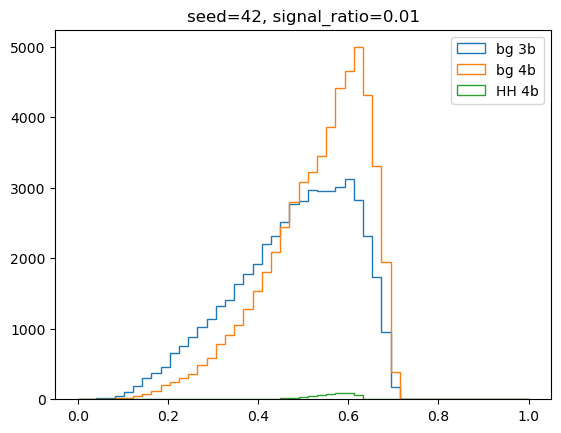

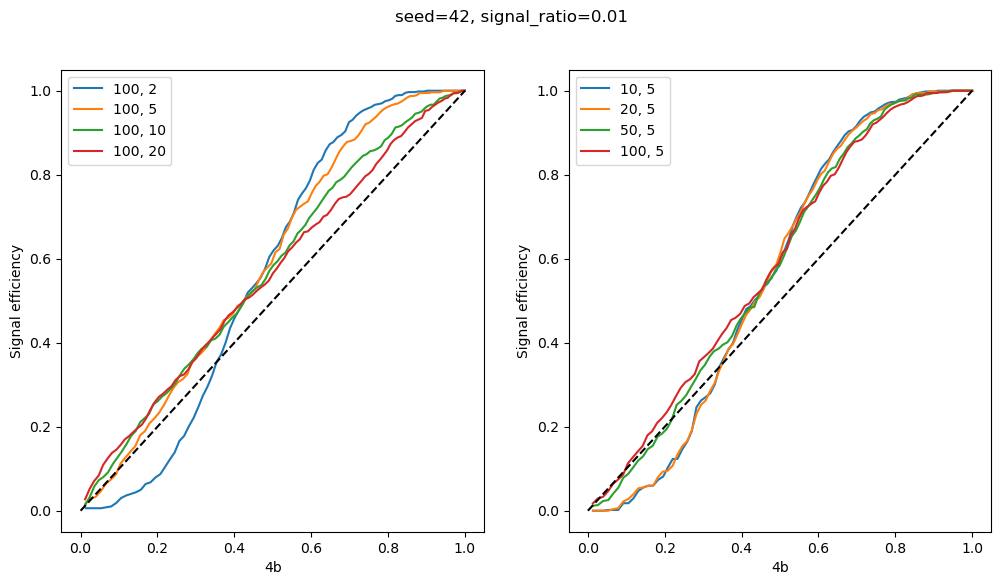

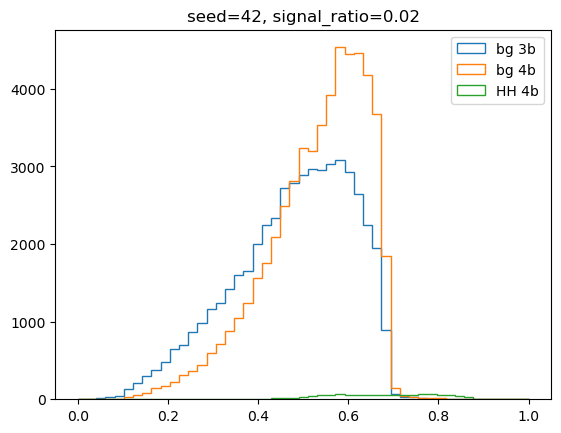

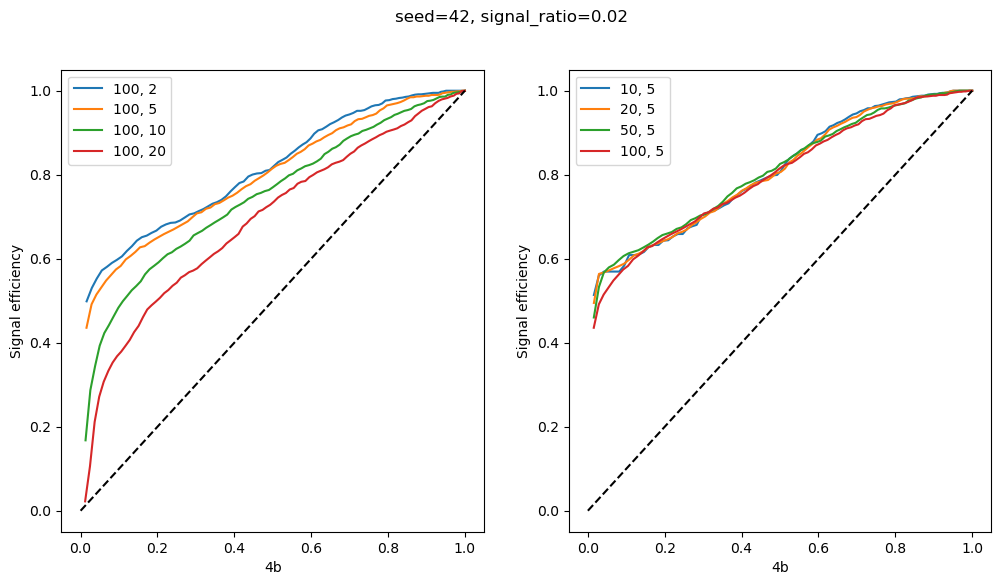

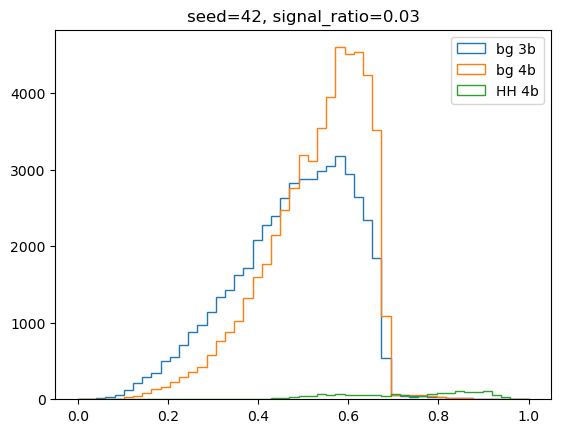

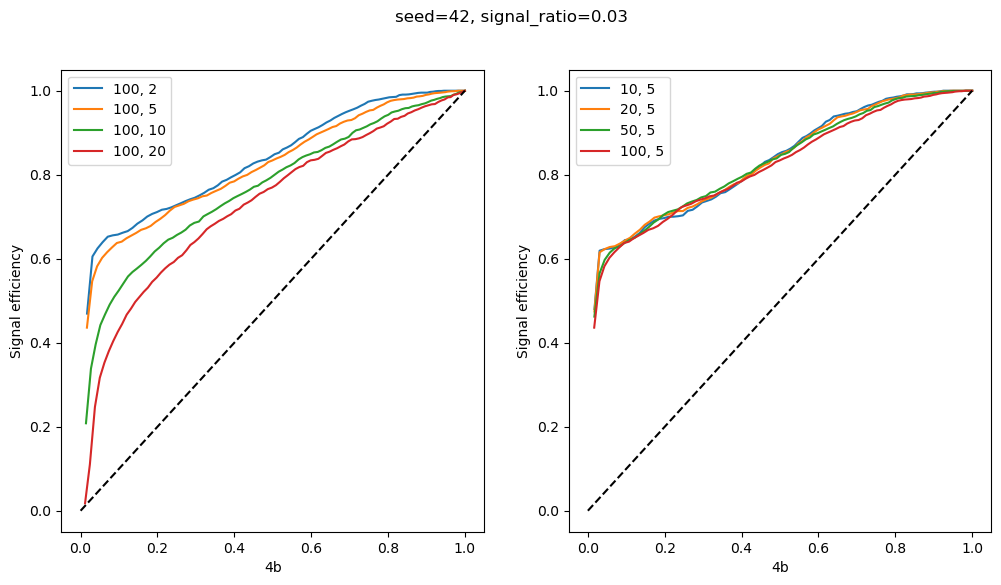

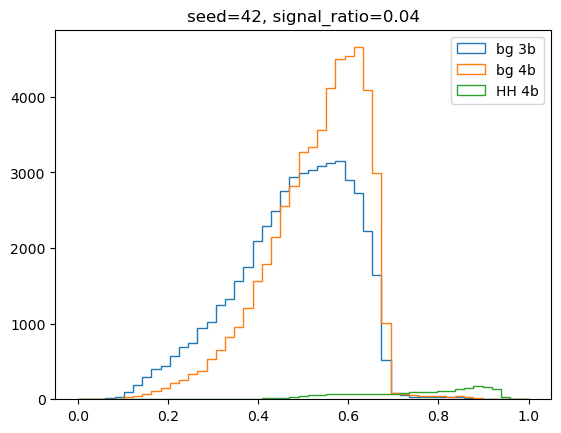

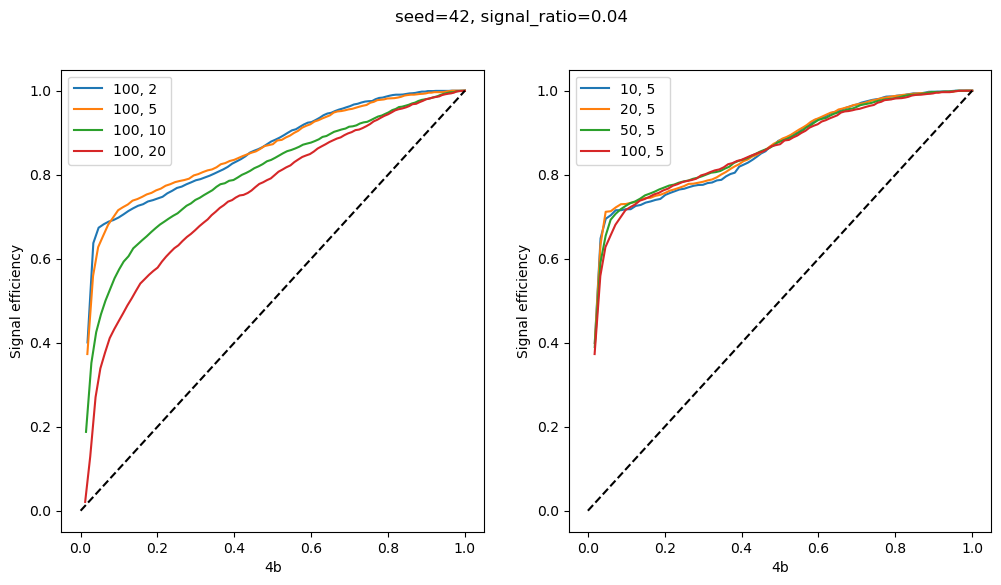

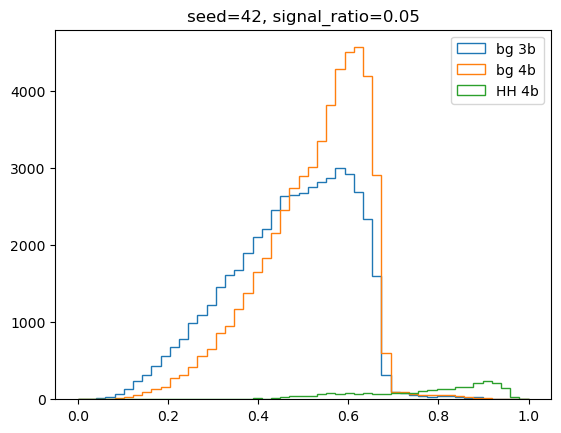

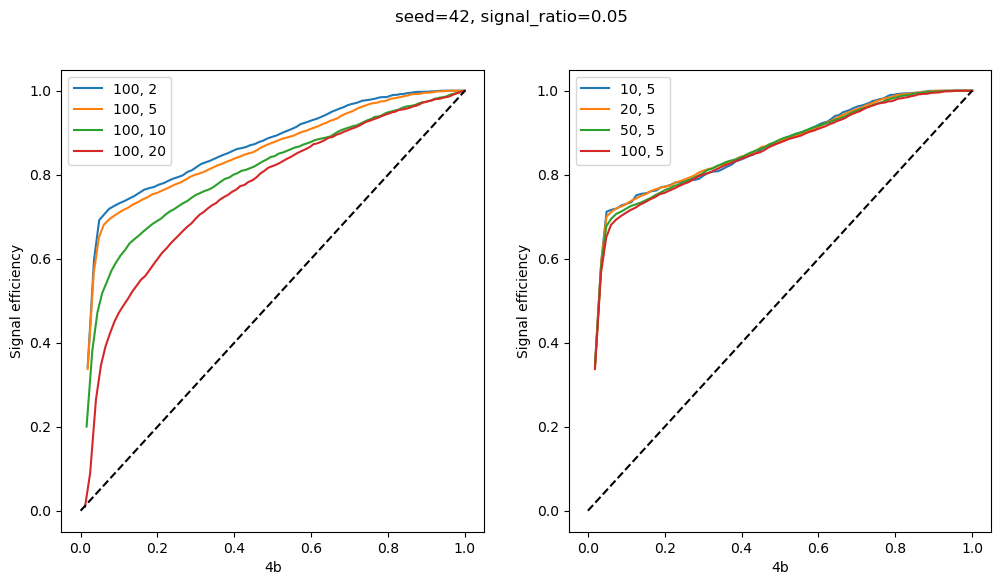

In [ ]:
best_n_estimator, best_max_depth = df.T.describe().loc["mean"].idxmax()

print(f"Best hparams: n_estimator={best_n_estimator}, max_depth={best_max_depth}")
# plots for best params



for seed in seeds:
    for signal_ratio in signal_ratios:
        events = events_test_dict[seed][signal_ratio]
        is_3b = events.is_3b
        is_bg4b = events.is_bg4b
        is_signal = events.is_signal
        is_4b = events.is_4b
        w = events.weights

        hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, 
                                  "signal_ratio": signal_ratio, "n_sample_ratio": 1.0})[0]
        tinfo = TrainingInfo.load(hash)
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_sr_train, events_sr_test = events.split(0.5, seed=seed)
        events_sr_train.set_model_scores(fvt_model)
        events_sr_test.set_model_scores(fvt_model)    

        fig, ax = plt.subplots()
        bins_range = np.linspace(0, 1, 50)
        ax.set_title(f"seed={seed}, signal_ratio={signal_ratio}")
        ax.hist(events_sr_test.fvt_score[events_sr_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax.hist(events_sr_test.fvt_score[events_sr_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax.hist(events_sr_test.fvt_score[events_sr_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax.legend()
        plt.show()
        plt.close()

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle(f"seed={seed}, signal_ratio={signal_ratio}")

        att_q_repr = att_q_reprs_dict[seed][signal_ratio]
        X_train = cp.array(events_sr_train.att_q_repr)
        y_train = cp.array(events_sr_train.is_4b)
        w_train = cp.array(events_sr_train.weights)

        for max_depth in max_depths:
            xgbreg = XGBRegressor(n_estimators=best_n_estimator, max_depth=max_depth, random_state=seed)
            xgbreg.fit(X_train, y_train, sample_weight=w_train)

            probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)

            w_signal = np.array([np.sum(events_sr_test.weights[events_sr_test.is_signal & is_in_regions]) 
                                for is_in_regions in is_in_regions_list]) / np.sum(
                                    events_sr_test.weights[events_sr_test.is_signal])
            w_4b = np.array([np.sum(events_sr_test.weights[events_sr_test.is_4b & is_in_regions]) 
                                for is_in_regions in is_in_regions_list]) / np.sum(
                                    events_sr_test.weights[events_sr_test.is_4b])
            w_all = np.array([np.sum(events_sr_test.weights[is_in_regions])
                                for is_in_regions in is_in_regions_list]) / np.sum(events_sr_test.weights)


            ax[0].plot( 
                w_4b,
                w_signal,
                label=f"{best_n_estimator}, {max_depth}",
            )

        ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")
        ax[0].set_xlabel("4b")
        ax[0].set_ylabel("Signal efficiency")
        ax[0].legend()
        
        for n_estimator in n_estimators:
            xgbreg = XGBRegressor(n_estimators=n_estimator, max_depth=best_max_depth, random_state=seed)
            xgbreg.fit(X_train, y_train, sample_weight=w_train)

            probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)

            w_signal = np.array([np.sum(events_sr_test.weights[events_sr_test.is_signal & is_in_regions]) 
                                for is_in_regions in is_in_regions_list]) / np.sum(
                                    events_sr_test.weights[events_sr_test.is_signal])
            w_4b = np.array([np.sum(events_sr_test.weights[events_sr_test.is_4b & is_in_regions])
                                    for is_in_regions in is_in_regions_list]) / np.sum(
                                        events_sr_test.weights[events_sr_test.is_4b])
            w_all = np.array([np.sum(events_sr_test.weights[is_in_regions])
                                for is_in_regions in is_in_regions_list]) / np.sum(events_sr_test.weights)


            ax[1].plot( 
                w_4b,
                w_signal,
                label=f"{n_estimator}, {best_max_depth}",
            )

        ax[1].plot([0, 1], [0, 1], linestyle="--", color="black")
        
        ax[1].set_xlabel("4b")
        ax[1].set_ylabel("Signal efficiency")
        ax[1].legend()

        plt.show()
        plt.close()

# Overfitting is the key?
With and without validation

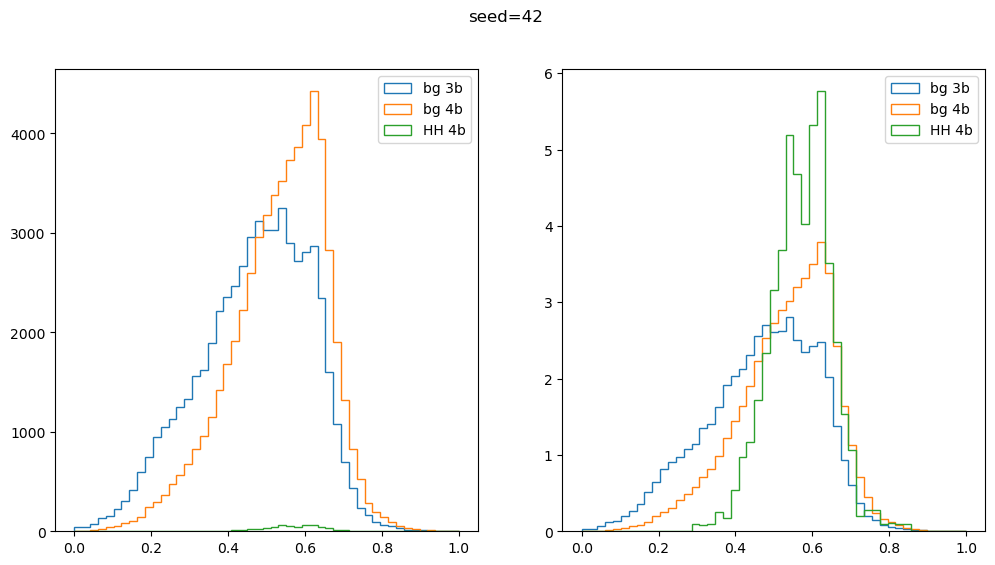

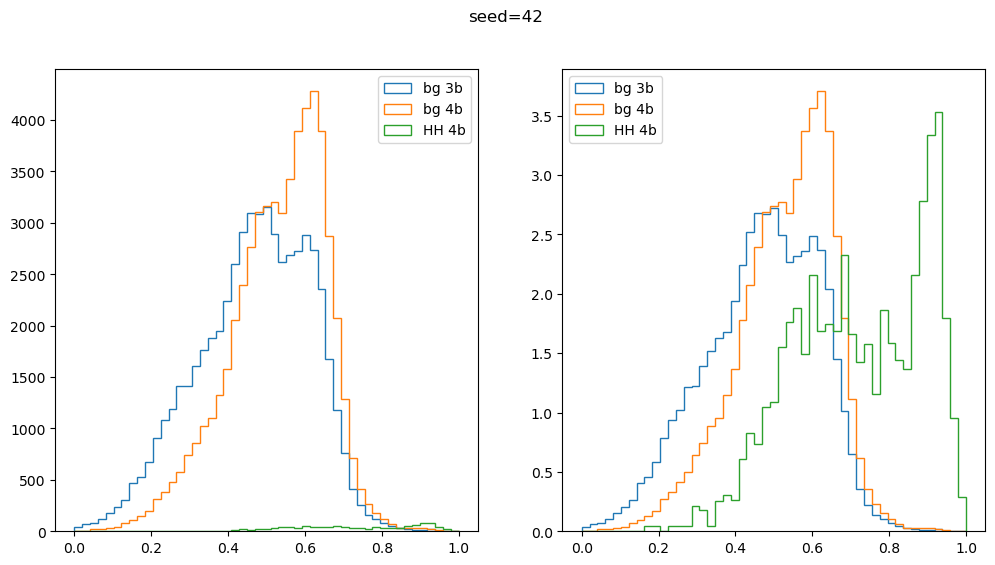

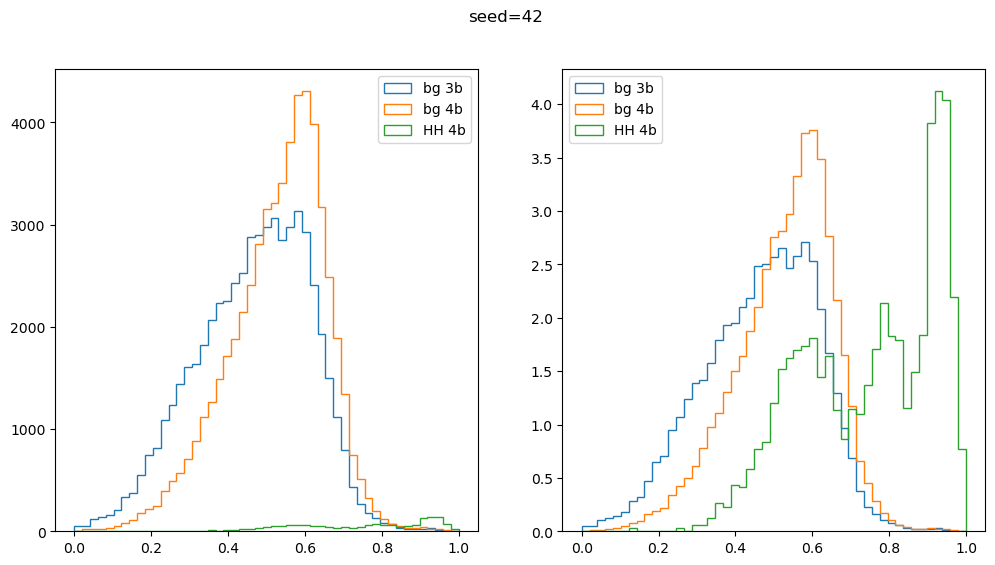

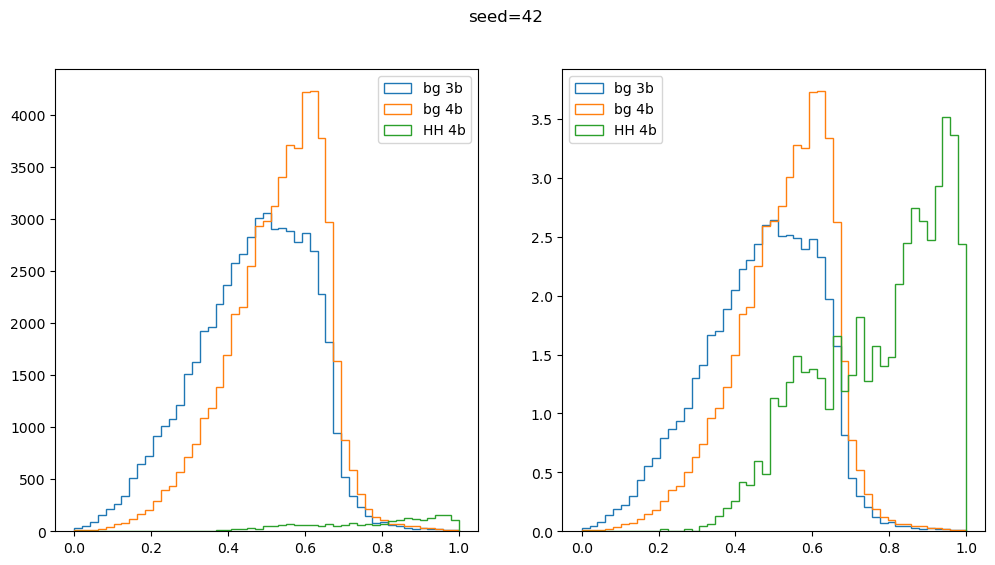

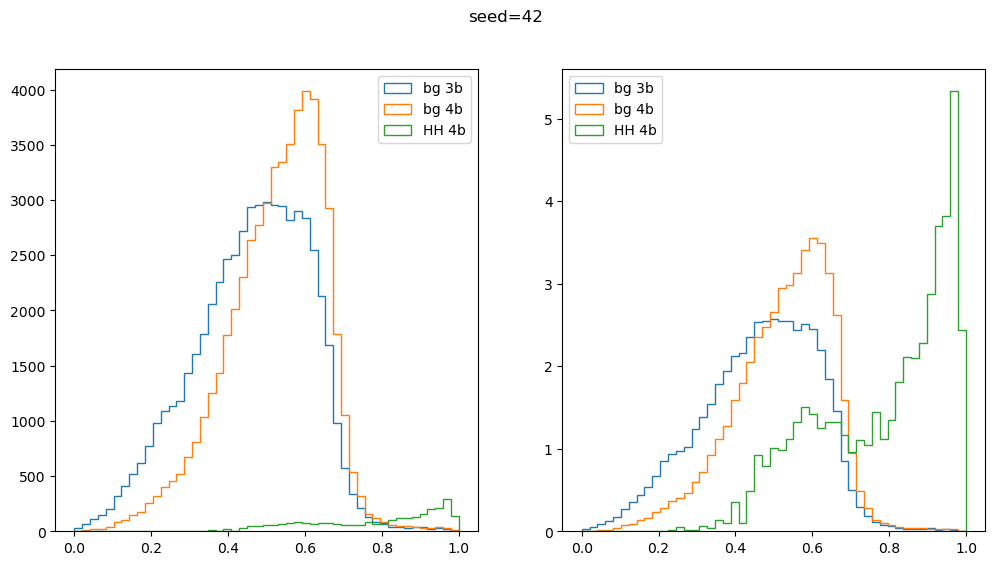

In [ ]:
for seed in seeds:
    for signal_ratio in signal_ratios:
        events = events_test_dict[seed][signal_ratio]
        
        hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, 
                                  "signal_ratio": signal_ratio, "n_sample_ratio": 1.0})[0]
        tinfo = TrainingInfo.load(hash)
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_sr_train, events_sr_test = events.split(0.5, seed=seed)
        events_sr_train.set_model_scores(fvt_model)
        events_sr_test.set_model_scores(fvt_model)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle(f"seed={seed}")

        xgbreg = XGBRegressor(n_estimators=best_n_estimator, max_depth=best_max_depth, random_state=seed)
        xgbreg.fit(events_sr_train.att_q_repr, events_sr_train.is_4b, sample_weight=events_sr_train.weights)
        probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)

        is_3b = events_sr_test.is_3b
        is_bg4b = events_sr_test.is_bg4b
        is_signal = events_sr_test.is_signal
        is_4b = events_sr_test.is_4b
        w = events_sr_test.weights

        bins_range = np.linspace(0, 1, 50)
        ax[0].hist(probs_4b_estimated[is_3b], bins=bins_range, weights=w[is_3b], label="bg 3b", histtype="step")
        ax[0].hist(probs_4b_estimated[is_bg4b], bins=bins_range, weights=w[is_bg4b], label="bg 4b", histtype="step")
        ax[0].hist(probs_4b_estimated[is_signal], bins=bins_range, weights=w[is_signal], label="HH 4b", histtype="step")
        
        ax[1].hist(probs_4b_estimated[is_3b], bins=bins_range, weights=w[is_3b], label="bg 3b", histtype="step", density=True)
        ax[1].hist(probs_4b_estimated[is_bg4b], bins=bins_range, weights=w[is_bg4b], label="bg 4b", histtype="step", density=True)
        ax[1].hist(probs_4b_estimated[is_signal], bins=bins_range, weights=w[is_signal], label="HH 4b", histtype="step", density=True)
            
        ax[0].legend()
        ax[1].legend()
        
        plt.show()
        plt.close()

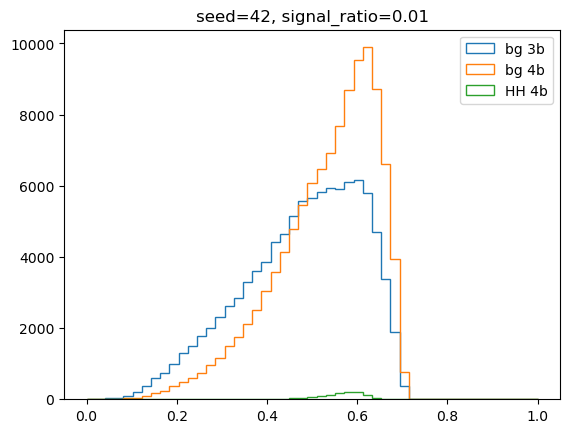

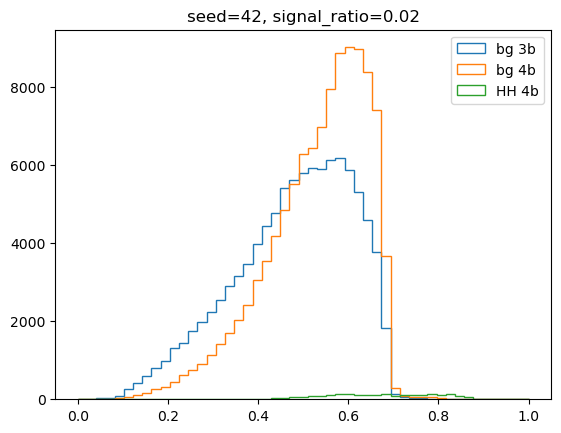

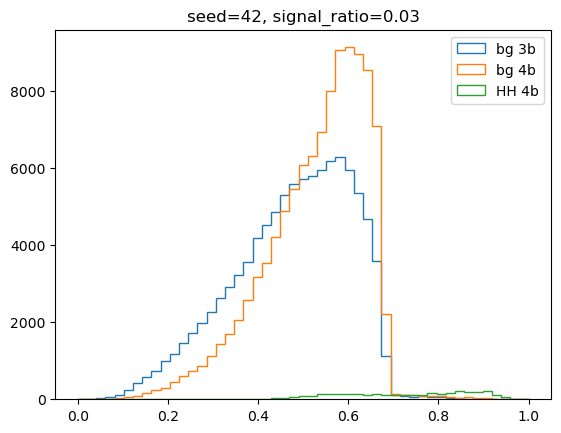

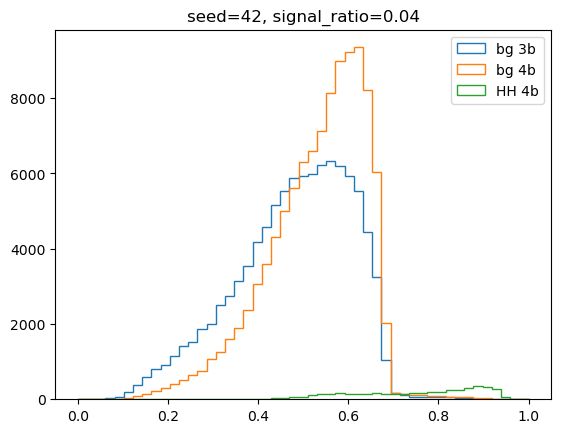

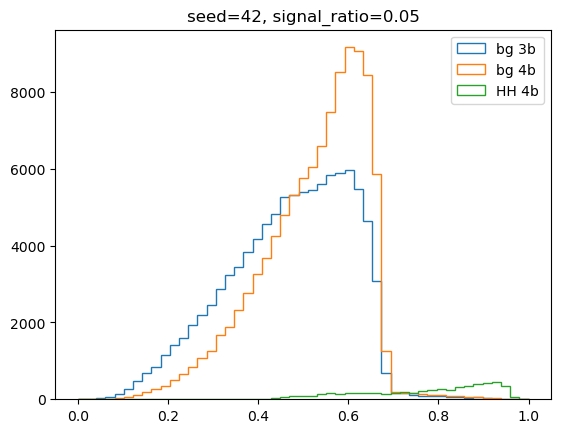

In [ ]:
for seed in seeds:
    for signal_ratio in signal_ratios:
        events = events_test_dict[seed][signal_ratio]
        fig, ax = plt.subplots()
        bins_range = np.linspace(0, 1, 50)
        ax.set_title(f"seed={seed}, signal_ratio={signal_ratio}")
        ax.hist(fvt_scores_dict[seed][signal_ratio][events.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax.hist(fvt_scores_dict[seed][signal_ratio][events.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax.hist(fvt_scores_dict[seed][signal_ratio][events.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax.legend()

        plt.show()
        plt.close()

In [ ]:
from ancillary_features import jets_to_dijets
from signal_region import get_regions_via_probs_4b
from xgboost import XGBRegressor


seed = 42
signal_ratio = 0.03
using_features = [0, 1, 2, 3, 4, 5]
w_cuts = np.arange(0.01, 1.01, 0.01)
# nbins = 4
# binning_method = "quantile"

events = events_test_dict[seed][signal_ratio]
att_q_repr = att_q_reprs_dict[seed][signal_ratio]

xgbreg = XGBRegressor(n_estimators=best_n_estimator, max_depth=best_max_depth, random_state=seed)
xgbreg.fit(att_q_repr, events.is_4b, sample_weight=events.weights)
probs_4b_est = xgbreg.predict(att_q_repr)
is_in_regions_list = get_regions_via_probs_4b(events, w_cuts, probs_4b_est)

jet0 = events.X_torch[:, [4*i for i in range(4)]]
jet1 = events.X_torch[:, [4*i + 1 for i in range(4)]]
jet2 = events.X_torch[:, [4*i + 2 for i in range(4)]]
jet3 = events.X_torch[:, [4*i + 3 for i in range(4)]]

dijet01, dijet23, dijet02, dijet13, dijet03, dijet12 = jets_to_dijets(jet0, jet1, jet2, jet3, dim=2)
M01, M23, M02, M13, M03, M12 = dijet01[:, 3], dijet23[:, 3], dijet02[:, 3], dijet13[:, 3], dijet03[:, 3], dijet12[:, 3]
M01, M23, M02, M13, M03, M12 = M01.cpu().numpy(), M23.cpu().numpy(), M02.cpu().numpy(), M13.cpu().numpy(), M03.cpu().numpy(), M12.cpu().numpy()

m_diff = np.stack(
    [M01 - M23, M02 - M13, M03 - M12],
    axis=1
)
m_diff_argmin = np.argmin(np.abs(m_diff), axis=1)

m_0 = np.where(m_diff_argmin == 0, M01, np.where(m_diff_argmin == 1, M02, M03))
m_1 = np.where(m_diff_argmin == 0, M23, np.where(m_diff_argmin == 1, M13, M12))

import plotly.express as px
import plotly.graph_objects as go

plot_w_cuts = np.arange(0.05, 1.0, 0.05)

fig_m0m1 = go.Figure()

# 2d histogram of m_0[is_in_regions] vs m_1[is_in_regions] for each w_cut
# use plotly express to plot the 2d histogram
# make plot_w_cuts a slider

hist_max = 0
for w_cut in plot_w_cuts:
    is_in_regions = is_in_regions_list[int(w_cut * 100)]


    x_bins = np.linspace(0, 200, 50)
    y_bins = np.linspace(0, 200, 50)

    hist_sr, _, _ = np.histogram2d(m_0[is_in_regions], m_1[is_in_regions], bins=(x_bins, y_bins),
                                    weights=events.weights[is_in_regions])
    hist_sr = hist_sr.T
    hist_sr /= np.sum(hist_sr)
    hist_max = max(hist_max, np.max(hist_sr))

for w_cut in plot_w_cuts:
    is_in_regions = is_in_regions_list[int(w_cut * 100)]


    x_bins = np.linspace(0, 200, 50)
    y_bins = np.linspace(0, 200, 50)

    hist_sr, _, _ = np.histogram2d(m_0[is_in_regions], m_1[is_in_regions], bins=(x_bins, y_bins),
                                    weights=events.weights[is_in_regions])
    hist_sr = hist_sr.T
    hist_sr /= np.sum(hist_sr)

    fig_m0m1.add_trace(
        go.Heatmap(
            x=x_bins,
            y=y_bins,
            z=hist_sr,
            zmin=0,
            zmax=hist_max,
            colorscale="Viridis",
            name=f"w_cut={w_cut:.1f}",
            visible=False,
        )
    )

fig_m0m1.data[0].visible = True

steps = []
for i in range(len(fig_m0m1.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig_m0m1.data)}],
        label=f"{plot_w_cuts[i]:.2f}",
    )
    step["args"][0]["visible"][i] = True
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "w_cut: "},
    pad={"t": 50},
    steps=steps
)]


fig_m0m1.update_layout(
    sliders=sliders,
    title="M_0 vs M_1 in signal region",
    xaxis_title="M_0",
    yaxis_title="M_1",
    autosize=False,
    width=600,
    height=600,
    yaxis=dict(scaleanchor="x", scaleratio=1),
)


fig_m0m1.show()

[0]	train-logloss:0.68135	test-logloss:0.64012
[1]	train-logloss:0.67692	test-logloss:0.59978
[2]	train-logloss:0.67526	test-logloss:0.57384
[3]	train-logloss:0.67532	test-logloss:0.55253
[4]	train-logloss:0.67694	test-logloss:0.53198
[5]	train-logloss:0.67869	test-logloss:0.51442
[6]	train-logloss:0.68103	test-logloss:0.50008
[7]	train-logloss:0.68220	test-logloss:0.49287
[8]	train-logloss:0.68365	test-logloss:0.48322
[9]	train-logloss:0.68511	test-logloss:0.47550
[10]	train-logloss:0.68617	test-logloss:0.46951
[11]	train-logloss:0.68767	test-logloss:0.46240
[12]	train-logloss:0.68848	test-logloss:0.45881
[13]	train-logloss:0.69020	test-logloss:0.45067
[14]	train-logloss:0.69148	test-logloss:0.44559
[15]	train-logloss:0.69232	test-logloss:0.44166
[16]	train-logloss:0.69282	test-logloss:0.43975
[17]	train-logloss:0.69357	test-logloss:0.43652
[18]	train-logloss:0.69447	test-logloss:0.43292
[19]	train-logloss:0.69509	test-logloss:0.43023
[20]	train-logloss:0.69558	test-logloss:0.42794
[2

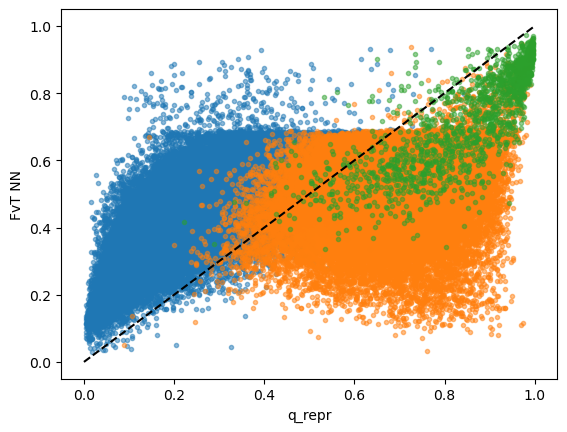

XGBoost
FvT NN


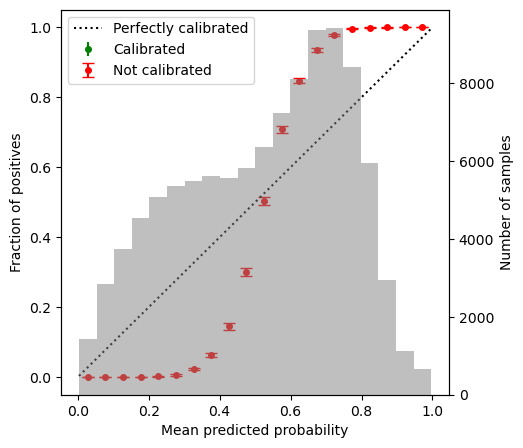

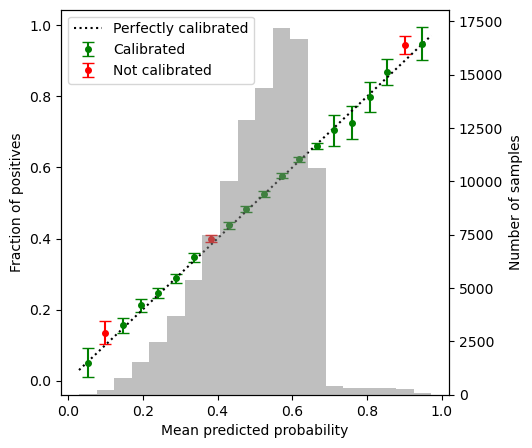

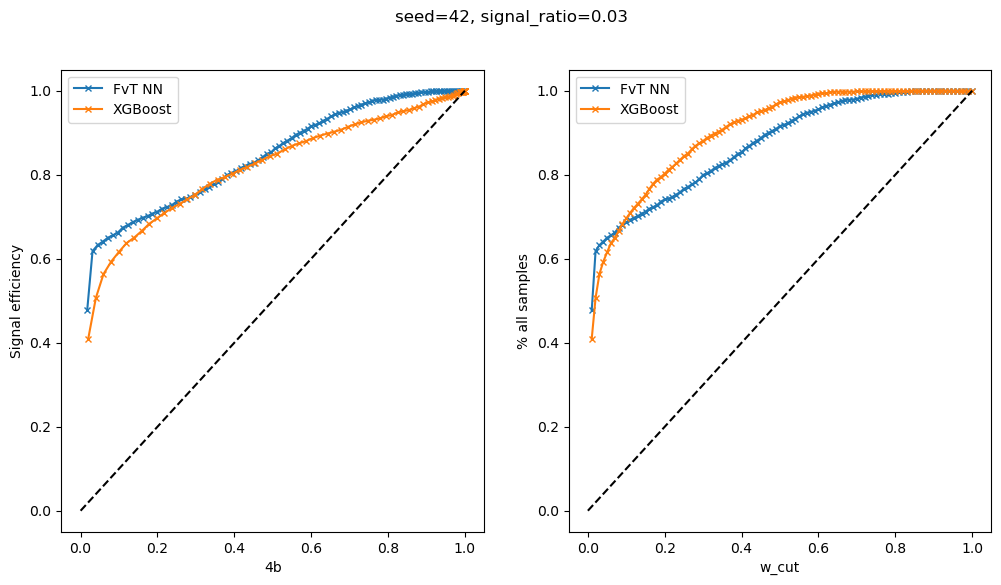

In [11]:
import xgboost as xgb

seed = 42
signal_ratio = 0.03
events = events_test_dict[seed][signal_ratio]
dim_quadjet_features = 6

hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, 
                            "signal_ratio": signal_ratio, "n_sample_ratio": 1.0})[0]
tinfo = TrainingInfo.load(hash)
fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
fvt_model.eval()
device = torch.device("cuda:0")
fvt_model = fvt_model.to(device)
events_sr_train, events_sr_test = events.split(0.5, seed=seed)
events_sr_train.set_model_scores(fvt_model)
events_sr_test.set_model_scores(fvt_model)

xgbreg = XGBRegressor(n_estimators=32, max_depth=16, random_state=seed, objective="binary:logistic")

params = {
    "objective": "binary:logistic",
    "max_depth": 16,
    "random_state": seed,
}
dtrain = xgb.DMatrix(events_sr_train.att_q_repr, label=events_sr_train.is_4b, weight=events_sr_train.weights)
dtest = xgb.DMatrix(events_sr_test.att_q_repr, label=events_sr_test.is_4b, weight=events_sr_test.weights)
watchlist = [(dtrain, "train"), (dtest, "test")]
bst = xgb.train(params, dtest, num_boost_round=32, evals=watchlist)
probs_4b_est = bst.predict(dtest)

is_3b = events_sr_test.is_3b
is_bg4b = events_sr_test.is_bg4b
is_signal = events_sr_test.is_signal

plt.plot(probs_4b_est[is_3b], events_sr_test.fvt_score[is_3b], ".", alpha=0.5)
plt.plot(probs_4b_est[is_bg4b], events_sr_test.fvt_score[is_bg4b], ".", alpha=0.5)
plt.plot(probs_4b_est[is_signal], events_sr_test.fvt_score[is_signal], ".", alpha=0.5)
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("q_repr")
plt.ylabel("FvT NN")
plt.show()
plt.close()

# calibration plot

from plots import calibration_plot

print("XGBoost")
calibration_plot(probs_4b_est, events_sr_test.is_4b, sample_weights=events_sr_test.weights)
print("FvT NN")
calibration_plot(events_sr_test.fvt_score, events_sr_test.is_4b, sample_weights=events_sr_test.weights)

w_cuts = np.arange(0.01, 1.01, 0.01)
is_in_regions_list_fvt = get_regions_via_probs_4b(events_sr_test, w_cuts, events_sr_test.fvt_score)
is_in_regions_list_xgb = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_est)

w_signal_fvt = np.array([np.sum(events_sr_test.weights[events_sr_test.is_signal & is_in_regions]) for is_in_regions in is_in_regions_list_fvt]) / np.sum(events_sr_test.weights[events_sr_test.is_signal])
w_all_fvt = np.array([np.sum(events_sr_test.weights[is_in_regions]) for is_in_regions in is_in_regions_list_fvt]) / np.sum(events_sr_test.weights)
w_4b_fvt = np.array([np.sum(events_sr_test.weights[events_sr_test.is_4b & is_in_regions]) for is_in_regions in is_in_regions_list_fvt]) / np.sum(events_sr_test.weights[events_sr_test.is_4b])

w_signal_xgb = np.array([np.sum(events_sr_test.weights[events_sr_test.is_signal & is_in_regions]) for is_in_regions in is_in_regions_list_xgb]) / np.sum(events_sr_test.weights[events_sr_test.is_signal])
w_all_xgb = np.array([np.sum(events_sr_test.weights[is_in_regions]) for is_in_regions in is_in_regions_list_xgb]) / np.sum(events_sr_test.weights)
w_4b_xgb = np.array([np.sum(events_sr_test.weights[events_sr_test.is_4b & is_in_regions]) for is_in_regions in is_in_regions_list_xgb]) / np.sum(events_sr_test.weights[events_sr_test.is_4b])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle(f"seed={seed}, signal_ratio={signal_ratio}")

ax[0].plot(
    w_4b_fvt,
    w_signal_fvt,
    label="FvT NN",
    marker="x",
    markersize=4
)
ax[0].plot(
    w_4b_xgb,
    w_signal_xgb,
    label="XGBoost",
    marker="x",
    markersize=4
)

ax[1].plot(
    w_all_fvt,
    w_signal_fvt,
    label="FvT NN",
    marker="x",
    markersize=4
)
ax[1].plot(
    w_all_xgb,
    w_signal_xgb,
    label="XGBoost",
    marker="x",
    markersize=4
)

ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")
ax[0].set_xlabel("4b")
ax[0].set_ylabel("Signal efficiency")
ax[0].legend()

ax[1].plot([0, 1], [0, 1], linestyle="--", color="black")
ax[1].set_xlabel("w_cut")
ax[1].set_ylabel("% all samples")
ax[1].legend()

plt.show()
plt.close()

In [ ]:
# fig = go.Figure()
# plot_w_cuts = np.arange(0.2, 1.0, 0.2)

# for w_cut in plot_w_cuts:
#     is_in_regions = is_in_regions_list[int(w_cut * 100)]

#     fig.add_trace(
#         go.Histogram(
#             x=events.fvt_score[is_in_regions],
#             xbins=dict(size=1/30),
#             histnorm="",
#             name=f"SR",
#             visible=False,
#         )
#     )

#     fig.add_trace(
#         go.Histogram(
#             x=events.fvt_score[~is_in_regions],
#             xbins=dict(size=1/30),
#             histnorm="",
#             name="not SR",
#             visible=False,
#         )
#     )

# fig.data[0].visible = True
# fig.data[1].visible = True

# steps = []
# for i in range(0, len(fig.data), 2):
#     step = dict(
#         method="update",
#         args=[{"visible": [False] * len(fig.data)}],
#         label=f"{plot_w_cuts[i // 2]:.2f}",
#     )
#     step["args"][0]["visible"][i] = True
#     step["args"][0]["visible"][i + 1] = True
#     steps.append(step)

# sliders = [dict(
#     active=0,
#     currentvalue={"prefix": "w_cut: "},
#     pad={"t": 50},
#     steps=steps
# )]

# fig.update_layout(
#     sliders=sliders,
#     title="FvT score in signal region",
#     xaxis_title="FvT score",
#     yaxis_title="Density",
# )

# fig.show()

0.5807392
0.5604429


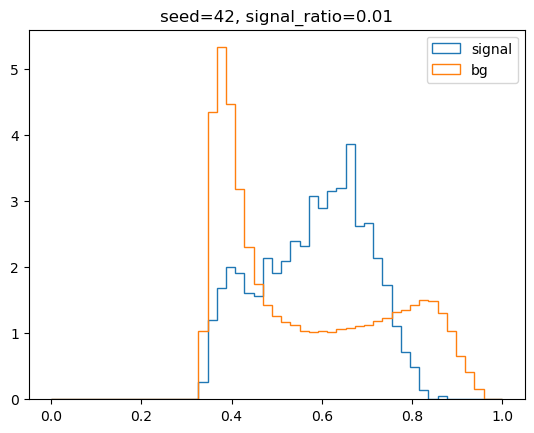

0.74831873
0.5779405


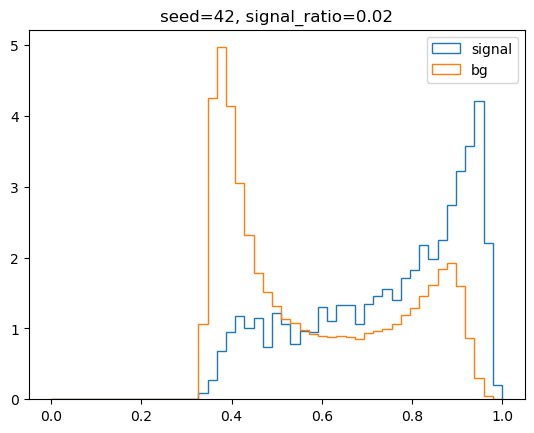

0.7868682
0.5952639


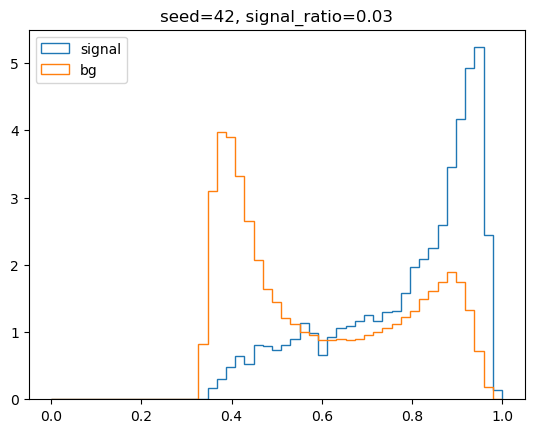

0.7844636
0.59795755


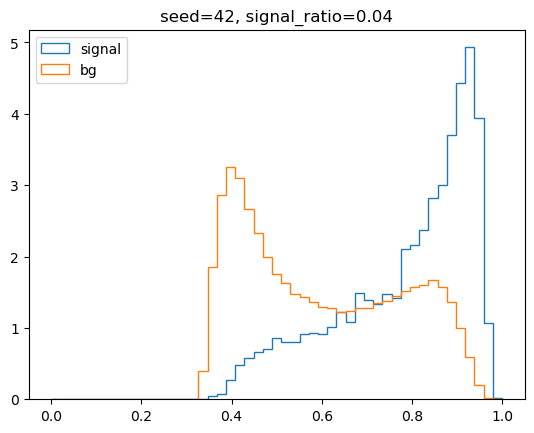

0.68365556
0.5249093


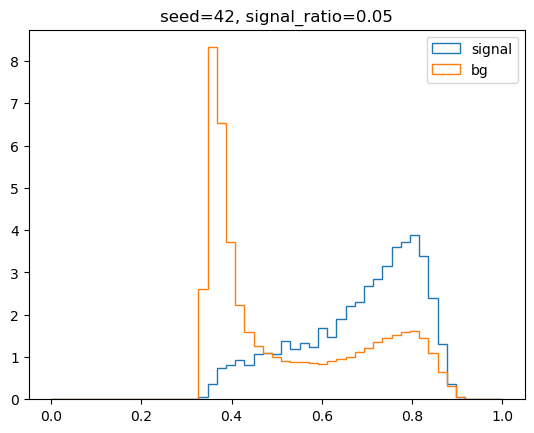

In [ ]:
seed = 42
for signal_ratio in signal_ratios:
    events = events_test_dict[seed][signal_ratio]

    max_score = np.max(events.view_score, axis=1)
    print(np.mean(max_score[events.is_signal]))
    print(np.mean(max_score[~events.is_signal]))

    plt.title(f"seed={seed}, signal_ratio={signal_ratio}")
    
    bins_range = np.linspace(0, 1, 50)
    plt.hist(max_score[events.is_signal], bins=bins_range, histtype="step", label="signal", density=True)
    plt.hist(max_score[~events.is_signal], bins=bins_range, histtype="step", label="bg", density=True)
    plt.legend()
    plt.show()


Signal 4b scores
View score agg:  0.5700796
XGBoost - q_repr and view_score:  0.56625867
XGBoost - att_q_repr:  0.5695719
FvT NN:  0.5618658


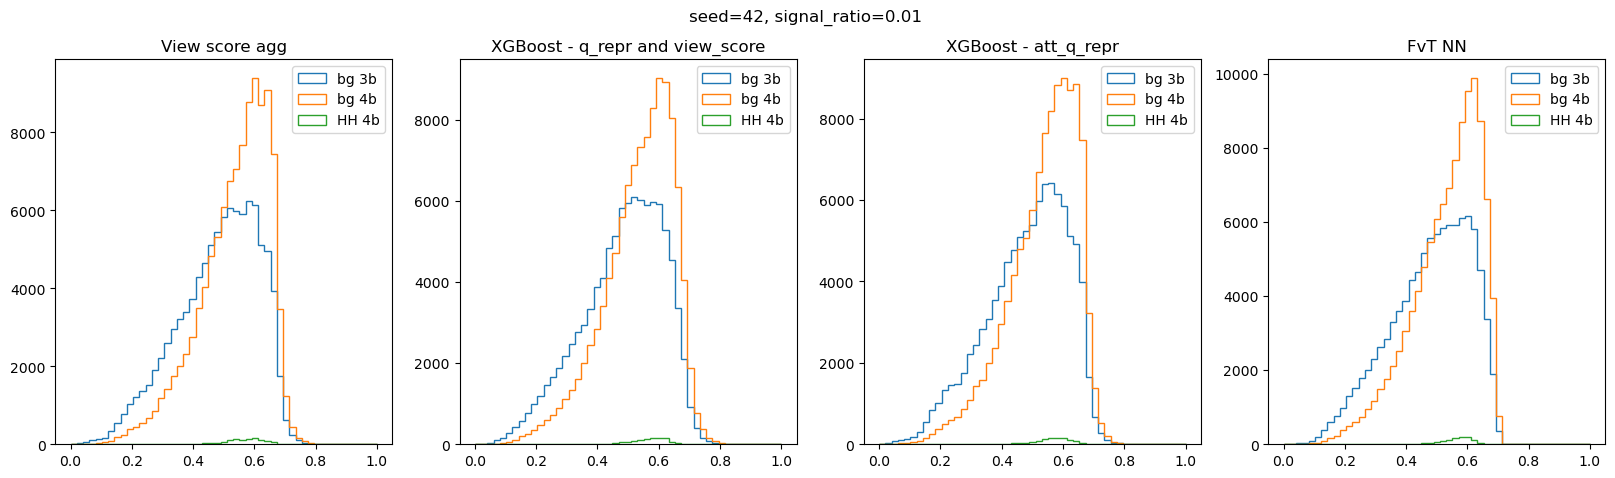

Signal 4b scores
View score agg:  0.704949
XGBoost - q_repr and view_score:  0.7010074
XGBoost - att_q_repr:  0.70572466
FvT NN:  0.6701955


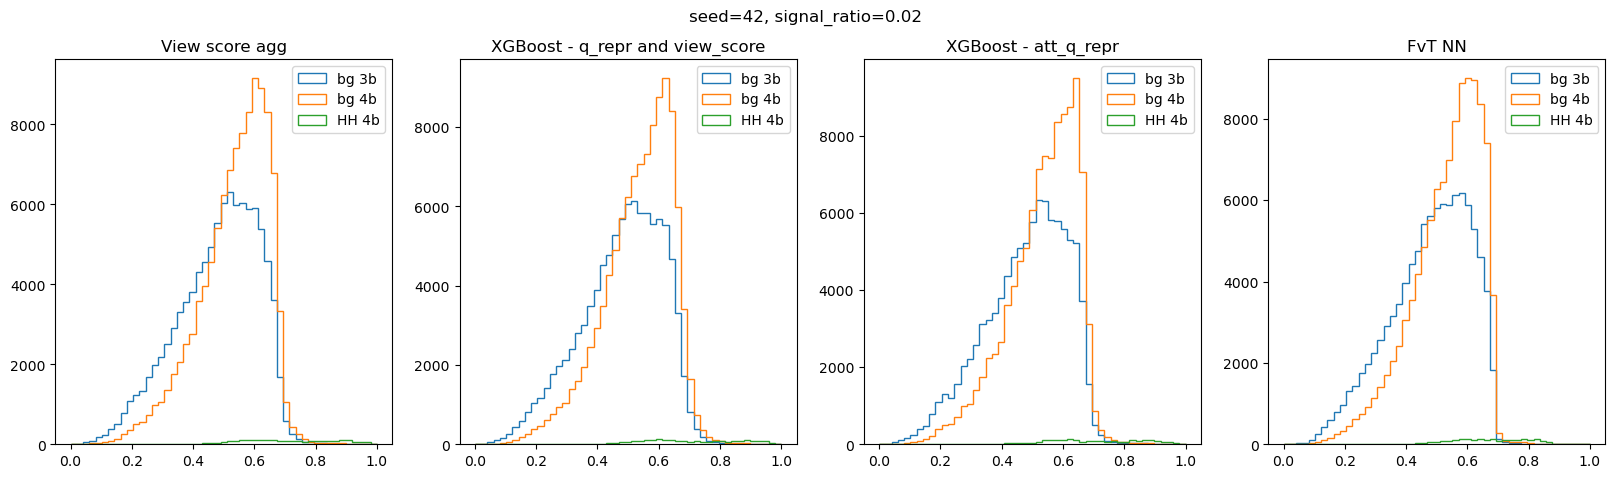

Signal 4b scores
View score agg:  0.73949885
XGBoost - q_repr and view_score:  0.7371902
XGBoost - att_q_repr:  0.74070436
FvT NN:  0.7260688


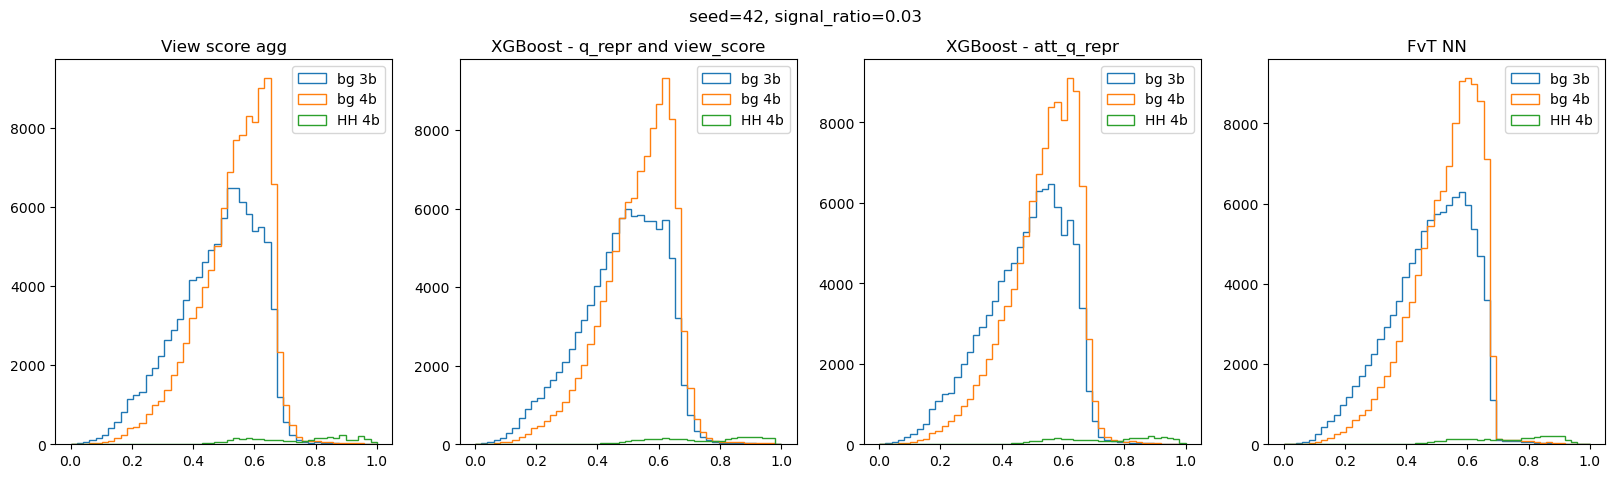

Signal 4b scores
View score agg:  0.7650257
XGBoost - q_repr and view_score:  0.76434267
XGBoost - att_q_repr:  0.76523894
FvT NN:  0.74771243


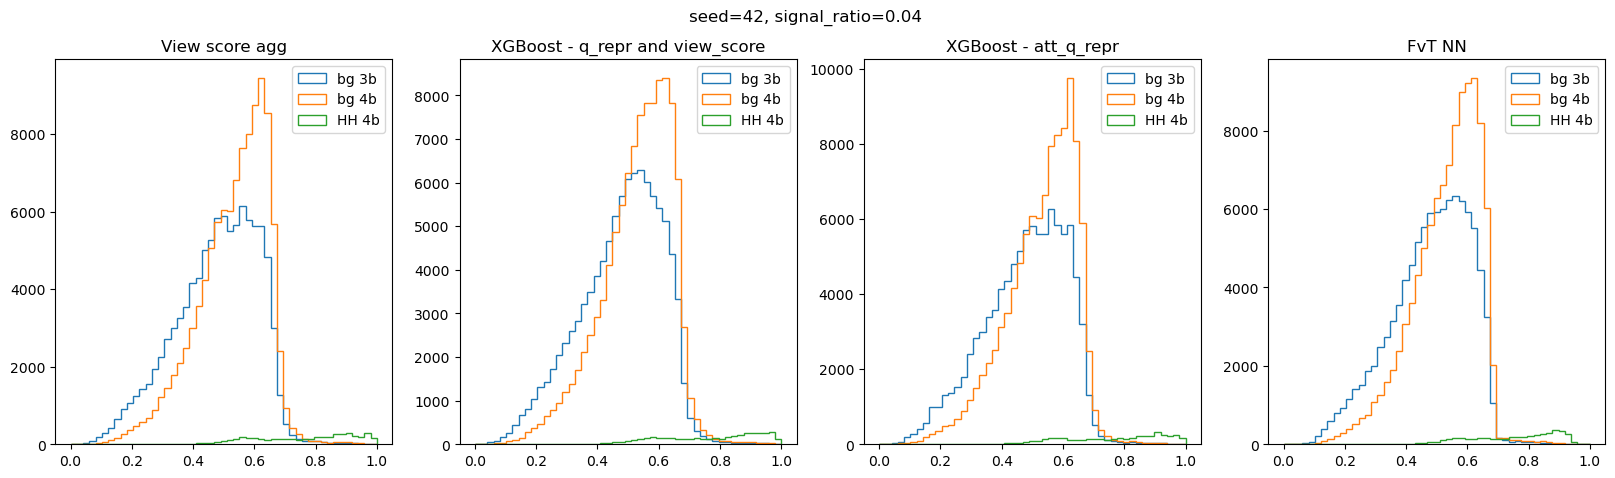

Signal 4b scores
View score agg:  0.784885
XGBoost - q_repr and view_score:  0.7822307
XGBoost - att_q_repr:  0.7842574
FvT NN:  0.7704406


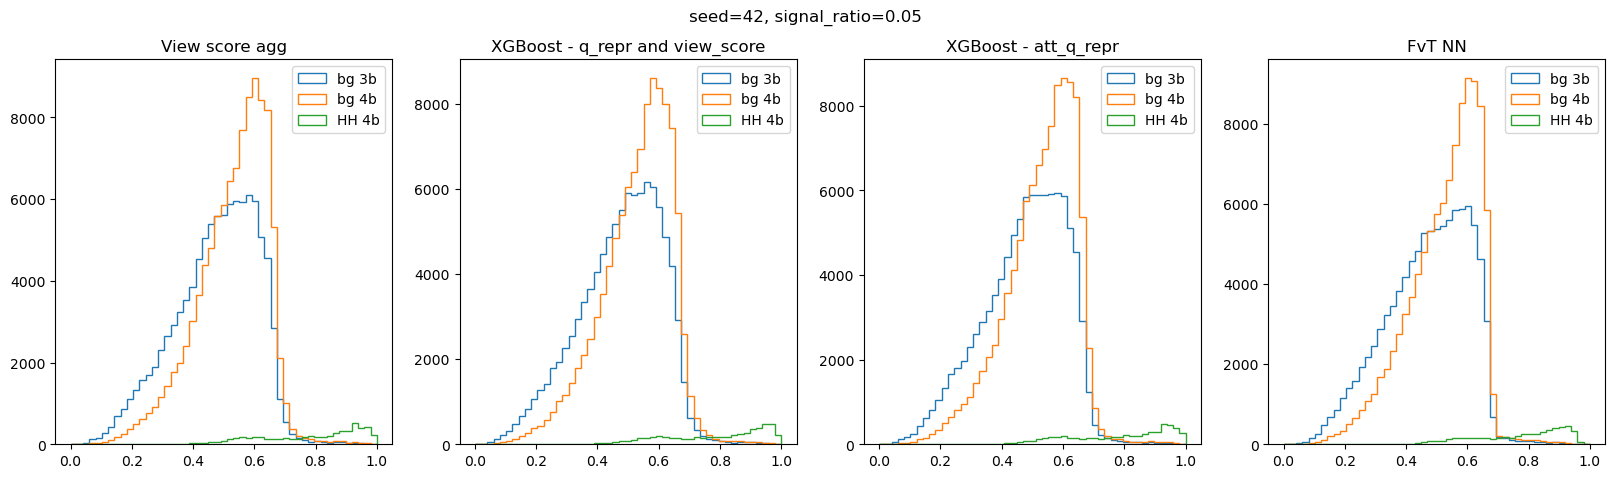

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

config_filename = "configs/fvt_training_higher_sr.yml"

config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
n_all4b = config["n_all4b"]
signal_ratio = config["signal_ratio"]
test_ratio = config["test_ratio"]
n_sample_ratios = [1.0]
seeds = [42]
w_cuts = np.arange(0.01, 1.01, 0.01)
signal_ratios = [0.01, 0.02, 0.03, 0.04, 0.05]
dim_quadjet_features = config["dim_quadjet_features"]

for seed in seeds:
    for signal_ratio in signal_ratios:
        dinfo_train, dinfo_test = generate_tt_dataset(
                seed,
                n_3b,
                n_all4b,
                signal_ratio,
                test_ratio,
            )
        xgbreg = XGBRegressor(n_estimators=100, max_depth=20, random_state=seed)
        
        events_train = EventsData.from_dataframe(dinfo_train.fetch_data(), features=features)
        events_xgb_train, events_xgb_val = events_train.split(0.67, seed=seed)
        events_test = EventsData.from_dataframe(dinfo_test.fetch_data(), features=features)

        hashes = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, 
                                    "signal_ratio": signal_ratio, "n_sample_ratio": 1.0})
        hash = hashes[0]
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        
        events_xgb_train.set_model_scores(fvt_model)
        events_xgb_val.set_model_scores(fvt_model)
        events_test.set_model_scores(fvt_model)

        param = {
        "max_depth": best_max_depth,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        }
        num_round = best_n_estimator

        # probs_4b_ests = []
        # for i in range(3):
        #     dtrain = xgb.DMatrix(events_xgb_train.q_repr[:, :, i], label=events_xgb_train.is_4b, weight=events_xgb_train.weights)
        #     dval = xgb.DMatrix(events_xgb_val.q_repr[:, :, i], label=events_xgb_val.is_4b, weight=events_xgb_val.weights)
        #     dtest = xgb.DMatrix(events_test.q_repr[:, :, i], label=events_test.is_4b, weight=events_test.weights)
        #     bst = xgb.train(param, dtrain, num_round, evals=[(dval, "eval")], early_stopping_rounds=100, verbose_eval=False)
        #     probs_4b_est = bst.predict(dtest)
        #     probs_4b_ests.append(probs_4b_est)

        # probs_4b_ests = np.stack(probs_4b_ests, axis=1)
        # probs_4b_estimated_vs_agg = np.sum(probs_4b_ests * events_test.view_score, axis=1)

        X_train = np.concatenate([events_xgb_train.att_q_repr, 
                                  np.max(events_xgb_train.view_score, axis=1, keepdims=True)], axis=1)
        dtrain = xgb.DMatrix(X_train, label=events_xgb_train.is_4b, weight=events_xgb_train.weights)
        X_val = np.concatenate([events_xgb_val.att_q_repr, 
                                  np.max(events_xgb_val.view_score, axis=1, keepdims=True)], axis=1)
        dval = xgb.DMatrix(X_val, label=events_xgb_val.is_4b, weight=events_xgb_val.weights)
        X_test = np.concatenate([events_test.att_q_repr, 
                                  np.max(events_test.view_score, axis=1, keepdims=True)], axis=1)
        dtest = xgb.DMatrix(X_test, label=events_test.is_4b, weight=events_test.weights)
        bst_q_repr = xgb.train(param, dtrain, num_round, evals=[(dval, "eval")], early_stopping_rounds=100, verbose_eval=False)
        probs_4b_estimated_vs_agg = bst_q_repr.predict(dtest)

        X_train = np.concatenate([events_xgb_train.q_repr.reshape(-1, 3 * dim_quadjet_features), events_xgb_train.view_score], axis=1)
        dtrain = xgb.DMatrix(X_train, label=events_xgb_train.is_4b, weight=events_xgb_train.weights)
        X_val = np.concatenate([events_xgb_val.q_repr.reshape(-1, 3 * dim_quadjet_features), events_xgb_val.view_score], axis=1)
        dval = xgb.DMatrix(X_val, label=events_xgb_val.is_4b, weight=events_xgb_val.weights)
        X_test = np.concatenate([events_test.q_repr.reshape(-1, 3 * dim_quadjet_features), events_test.view_score], axis=1)
        dtest = xgb.DMatrix(X_test, label=events_test.is_4b, weight=events_test.weights)
        bst_q_repr = xgb.train(param, dtrain, num_round, evals=[(dval, "eval")], early_stopping_rounds=100, verbose_eval=False)
        probs_4b_estimated_q_repr = bst_q_repr.predict(dtest)
        
        dtrain = xgb.DMatrix(events_xgb_train.att_q_repr, label=events_xgb_train.is_4b, weight=events_xgb_train.weights)
        dval = xgb.DMatrix(events_xgb_val.att_q_repr, label=events_xgb_val.is_4b, weight=events_xgb_val.weights)
        dtest = xgb.DMatrix(events_test.att_q_repr, label=events_test.is_4b, weight=events_test.weights)
        bst_att_q_repr = xgb.train(param, dtrain, num_round, evals=[(dval, "eval")], early_stopping_rounds=100, verbose_eval=False)
        probs_4b_estimated_att_q_repr = bst_att_q_repr.predict(dtest)

        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
        fig.suptitle(f"seed={seed}, signal_ratio={signal_ratio}")
        
        bins_range = np.linspace(0, 1, 50)
        ax[0].set_title("View score agg")
        ax[0].hist(probs_4b_estimated_vs_agg[events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax[0].hist(probs_4b_estimated_vs_agg[events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax[0].hist(probs_4b_estimated_vs_agg[events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax[0].legend()
        
        ax[1].set_title("XGBoost - q_repr and view_score")
        ax[1].hist(probs_4b_estimated_q_repr[events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax[1].hist(probs_4b_estimated_q_repr[events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax[1].hist(probs_4b_estimated_q_repr[events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax[1].legend()
        
        ax[2].set_title("XGBoost - att_q_repr")
        ax[2].hist(probs_4b_estimated_att_q_repr[events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax[2].hist(probs_4b_estimated_att_q_repr[events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax[2].hist(probs_4b_estimated_att_q_repr[events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax[2].legend()

        ax[3].set_title("FvT NN")
        ax[3].hist(events_test.fvt_score[events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax[3].hist(events_test.fvt_score[events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax[3].hist(events_test.fvt_score[events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax[3].legend()
        
        print("Signal 4b scores")
        print("View score agg: ", np.mean(probs_4b_estimated_vs_agg[events_test.is_signal]))
        print("XGBoost - q_repr and view_score: ", np.mean(probs_4b_estimated_q_repr[events_test.is_signal]))
        print("XGBoost - att_q_repr: ", np.mean(probs_4b_estimated_att_q_repr[events_test.is_signal]))
        print("FvT NN: ", np.mean(events_test.fvt_score[events_test.is_signal]))

        plt.show()
        plt.close()

        

# What if we naively use XGBoost on original features?

Signal 4b scores
XGBoost - original features:  0.5358688
XGBoost - q_repr and view_score:  0.56625867
XGBoost - att_q_repr:  0.5695719
FvT NN:  0.5618658


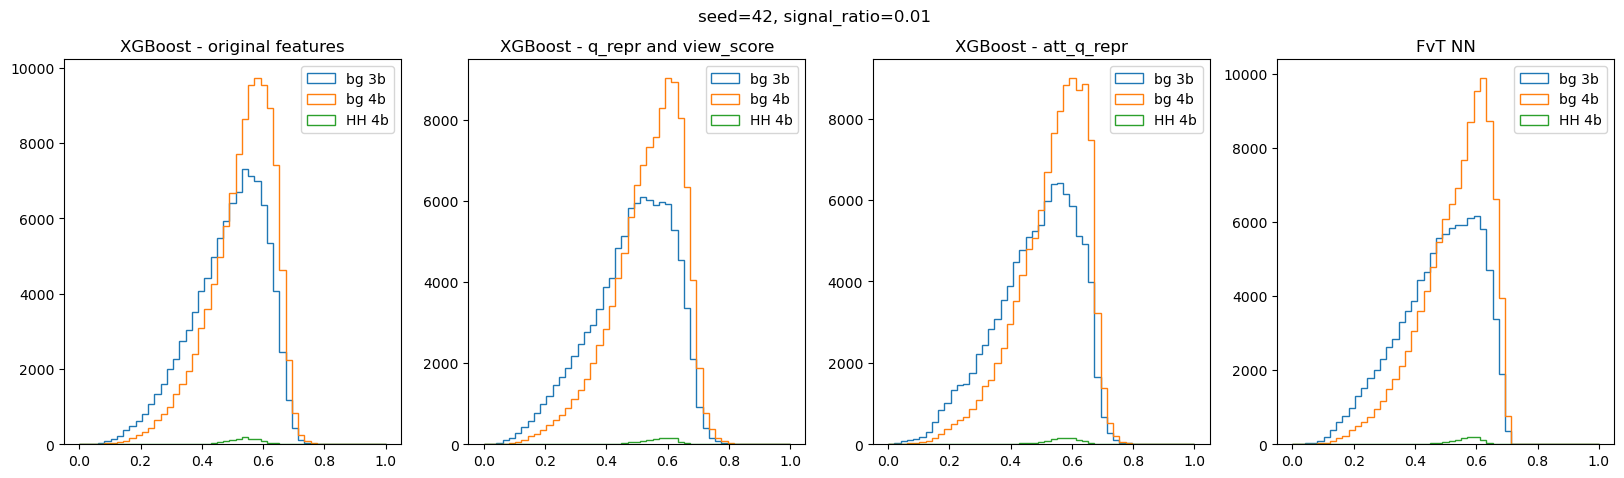

Signal 4b scores
XGBoost - original features:  0.54302514
XGBoost - q_repr and view_score:  0.7010074
XGBoost - att_q_repr:  0.70572466
FvT NN:  0.6701955


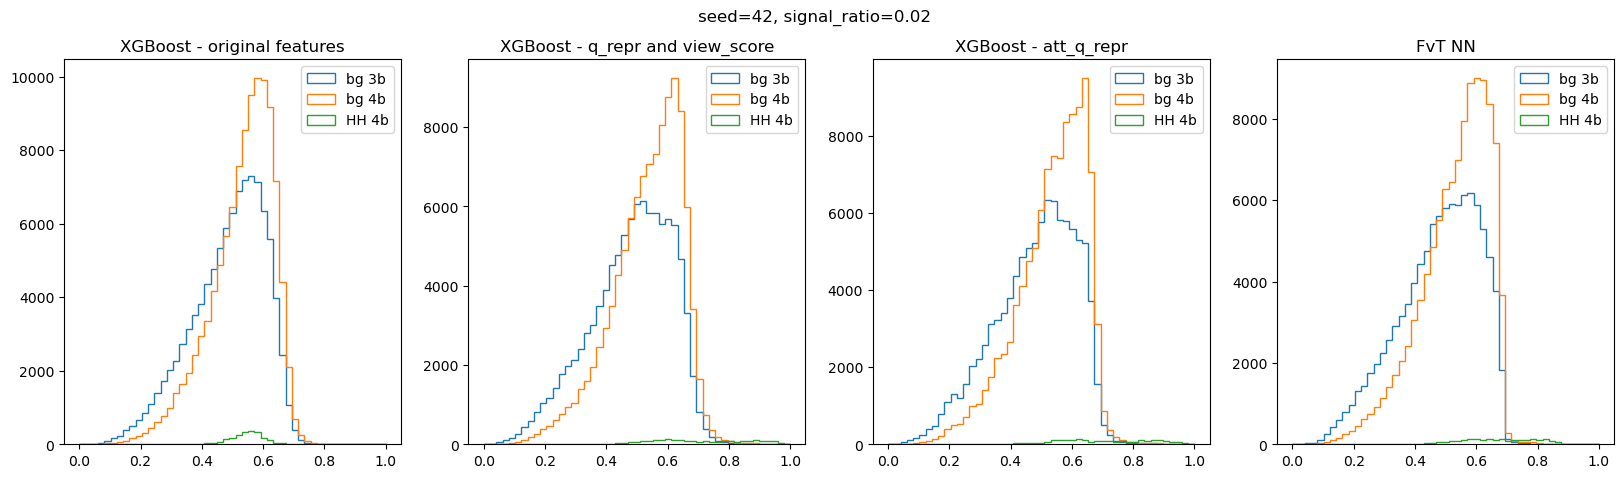

Signal 4b scores
XGBoost - original features:  0.549851
XGBoost - q_repr and view_score:  0.7371902
XGBoost - att_q_repr:  0.74070436
FvT NN:  0.7260688


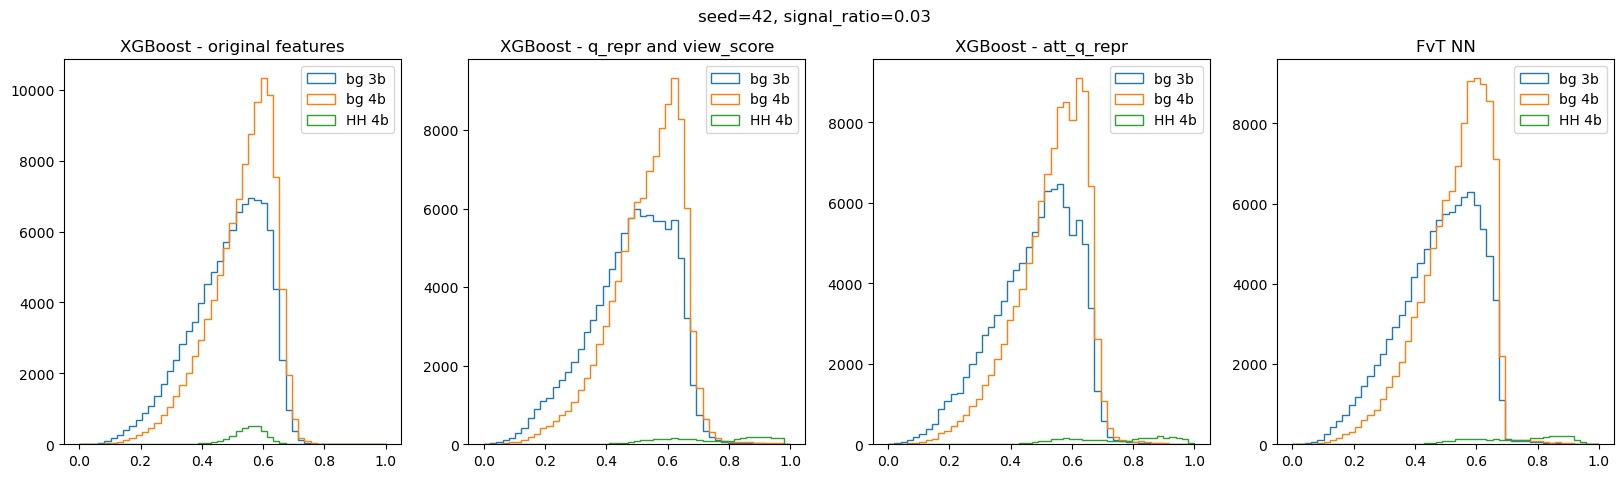

Signal 4b scores
XGBoost - original features:  0.55812657
XGBoost - q_repr and view_score:  0.76434267
XGBoost - att_q_repr:  0.76523894
FvT NN:  0.74771243


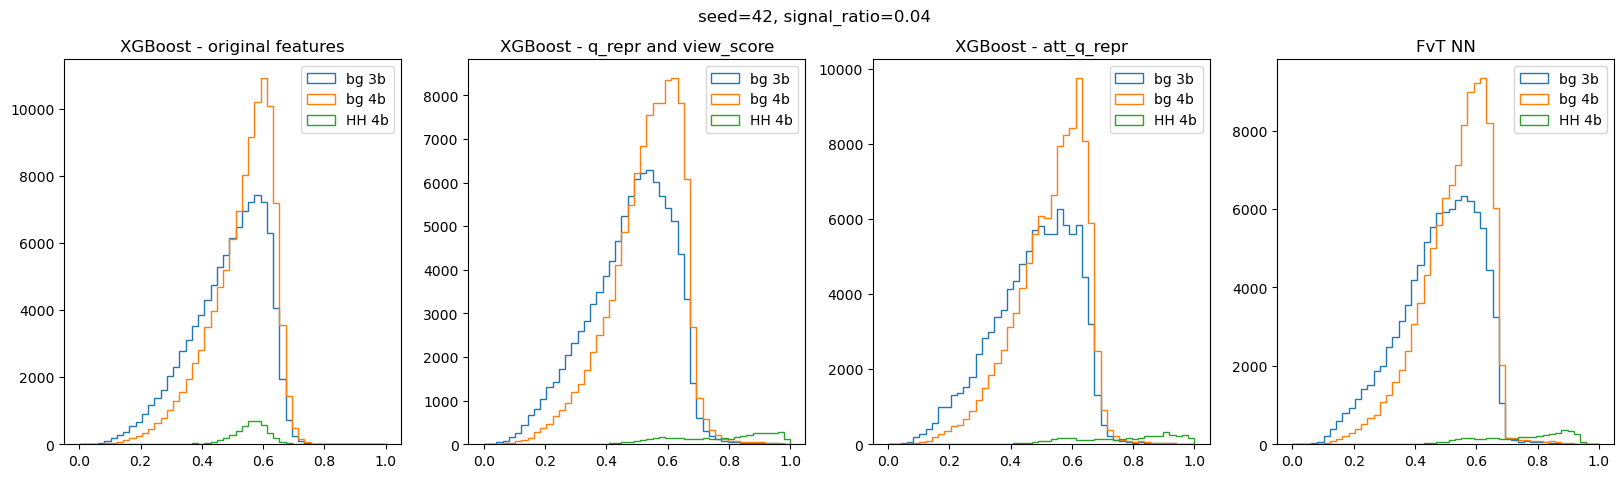

Signal 4b scores
XGBoost - original features:  0.56450975
XGBoost - q_repr and view_score:  0.7822307
XGBoost - att_q_repr:  0.7842574
FvT NN:  0.7704406


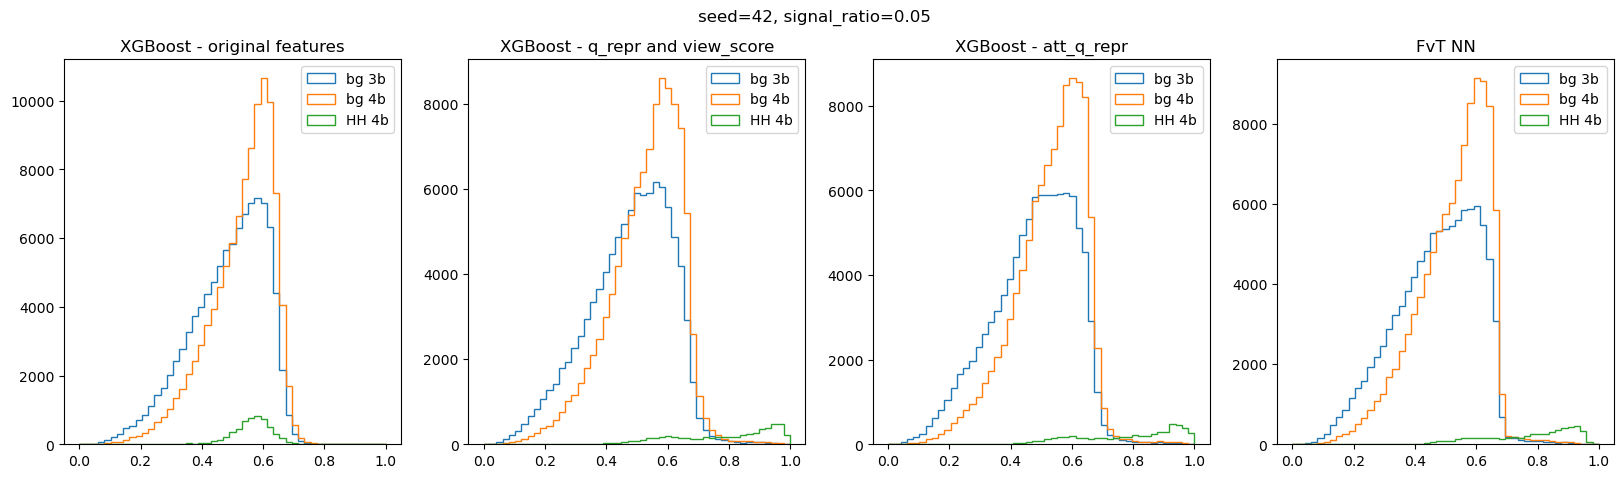

In [19]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

config_filename = "configs/fvt_training_higher_sr.yml"

config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
n_all4b = config["n_all4b"]
signal_ratio = config["signal_ratio"]
test_ratio = config["test_ratio"]
n_sample_ratios = [1.0]
seeds = [42]
w_cuts = np.arange(0.01, 1.01, 0.01)
signal_ratios = [0.01, 0.02, 0.03, 0.04, 0.05]
dim_quadjet_features = config["dim_quadjet_features"]

for seed in seeds:
    for signal_ratio in signal_ratios:
        dinfo_train, dinfo_test = generate_tt_dataset(
                seed,
                n_3b,
                n_all4b,
                signal_ratio,
                test_ratio,
            )
        xgbreg = XGBRegressor(n_estimators=100, max_depth=20, random_state=seed)
        
        events_train = EventsData.from_dataframe(dinfo_train.fetch_data(), features=features)
        events_xgb_train, events_xgb_val = events_train.split(0.67, seed=seed)
        events_test = EventsData.from_dataframe(dinfo_test.fetch_data(), features=features)

        hashes = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, 
                                    "signal_ratio": signal_ratio, "n_sample_ratio": 1.0})
        hash = hashes[0]
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        
        events_xgb_train.set_model_scores(fvt_model)
        events_xgb_val.set_model_scores(fvt_model)
        events_test.set_model_scores(fvt_model)

        param = {
        "max_depth": best_max_depth,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        }
        num_round = best_n_estimator

        dtrain = xgb.DMatrix(events_xgb_train.X, label=events_xgb_train.is_4b, weight=events_xgb_train.weights)
        dval = xgb.DMatrix(events_xgb_val.X, label=events_xgb_val.is_4b, weight=events_xgb_val.weights)
        dtest = xgb.DMatrix(events_test.X, label=events_test.is_4b, weight=events_test.weights)
        bst_orig = xgb.train(param, dtrain, num_round, evals=[(dval, "eval")], early_stopping_rounds=100, verbose_eval=False)
        probs_4b_estimated_orig = bst_orig.predict(dtest)
        
        X_train = np.concatenate([events_xgb_train.q_repr.reshape(-1, 3 * dim_quadjet_features), events_xgb_train.view_score], axis=1)
        dtrain = xgb.DMatrix(X_train, label=events_xgb_train.is_4b, weight=events_xgb_train.weights)
        X_val = np.concatenate([events_xgb_val.q_repr.reshape(-1, 3 * dim_quadjet_features), events_xgb_val.view_score], axis=1)
        dval = xgb.DMatrix(X_val, label=events_xgb_val.is_4b, weight=events_xgb_val.weights)
        X_test = np.concatenate([events_test.q_repr.reshape(-1, 3 * dim_quadjet_features), events_test.view_score], axis=1)
        dtest = xgb.DMatrix(X_test, label=events_test.is_4b, weight=events_test.weights)
        bst_q_repr = xgb.train(param, dtrain, num_round, evals=[(dval, "eval")], early_stopping_rounds=100, verbose_eval=False)
        probs_4b_estimated_q_repr = bst_q_repr.predict(dtest)
        
        dtrain = xgb.DMatrix(events_xgb_train.att_q_repr, label=events_xgb_train.is_4b, weight=events_xgb_train.weights)
        dval = xgb.DMatrix(events_xgb_val.att_q_repr, label=events_xgb_val.is_4b, weight=events_xgb_val.weights)
        dtest = xgb.DMatrix(events_test.att_q_repr, label=events_test.is_4b, weight=events_test.weights)
        bst_att_q_repr = xgb.train(param, dtrain, num_round, evals=[(dval, "eval")], early_stopping_rounds=100, verbose_eval=False)
        probs_4b_estimated_att_q_repr = bst_att_q_repr.predict(dtest)

        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
        fig.suptitle(f"seed={seed}, signal_ratio={signal_ratio}")
        
        bins_range = np.linspace(0, 1, 50)
        ax[0].set_title("XGBoost - original features")
        ax[0].hist(probs_4b_estimated_orig[events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax[0].hist(probs_4b_estimated_orig[events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax[0].hist(probs_4b_estimated_orig[events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax[0].legend()
        
        ax[1].set_title("XGBoost - q_repr and view_score")
        ax[1].hist(probs_4b_estimated_q_repr[events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax[1].hist(probs_4b_estimated_q_repr[events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax[1].hist(probs_4b_estimated_q_repr[events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax[1].legend()
        
        ax[2].set_title("XGBoost - att_q_repr")
        ax[2].hist(probs_4b_estimated_att_q_repr[events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax[2].hist(probs_4b_estimated_att_q_repr[events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax[2].hist(probs_4b_estimated_att_q_repr[events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax[2].legend()

        ax[3].set_title("FvT NN")
        ax[3].hist(events_test.fvt_score[events_test.is_3b], label="bg 3b", histtype="step", bins=bins_range)
        ax[3].hist(events_test.fvt_score[events_test.is_bg4b], label="bg 4b", histtype="step", bins=bins_range)
        ax[3].hist(events_test.fvt_score[events_test.is_signal], label="HH 4b", histtype="step", bins=bins_range)
        ax[3].legend()
        
        print("Signal 4b scores")
        print("XGBoost - original features: ", np.mean(probs_4b_estimated_orig[events_test.is_signal]))
        print("XGBoost - q_repr and view_score: ", np.mean(probs_4b_estimated_q_repr[events_test.is_signal]))
        print("XGBoost - att_q_repr: ", np.mean(probs_4b_estimated_att_q_repr[events_test.is_signal]))
        print("FvT NN: ", np.mean(events_test.fvt_score[events_test.is_signal]))

        plt.show()
        plt.close()

        

# Plot q_repr in signal region 

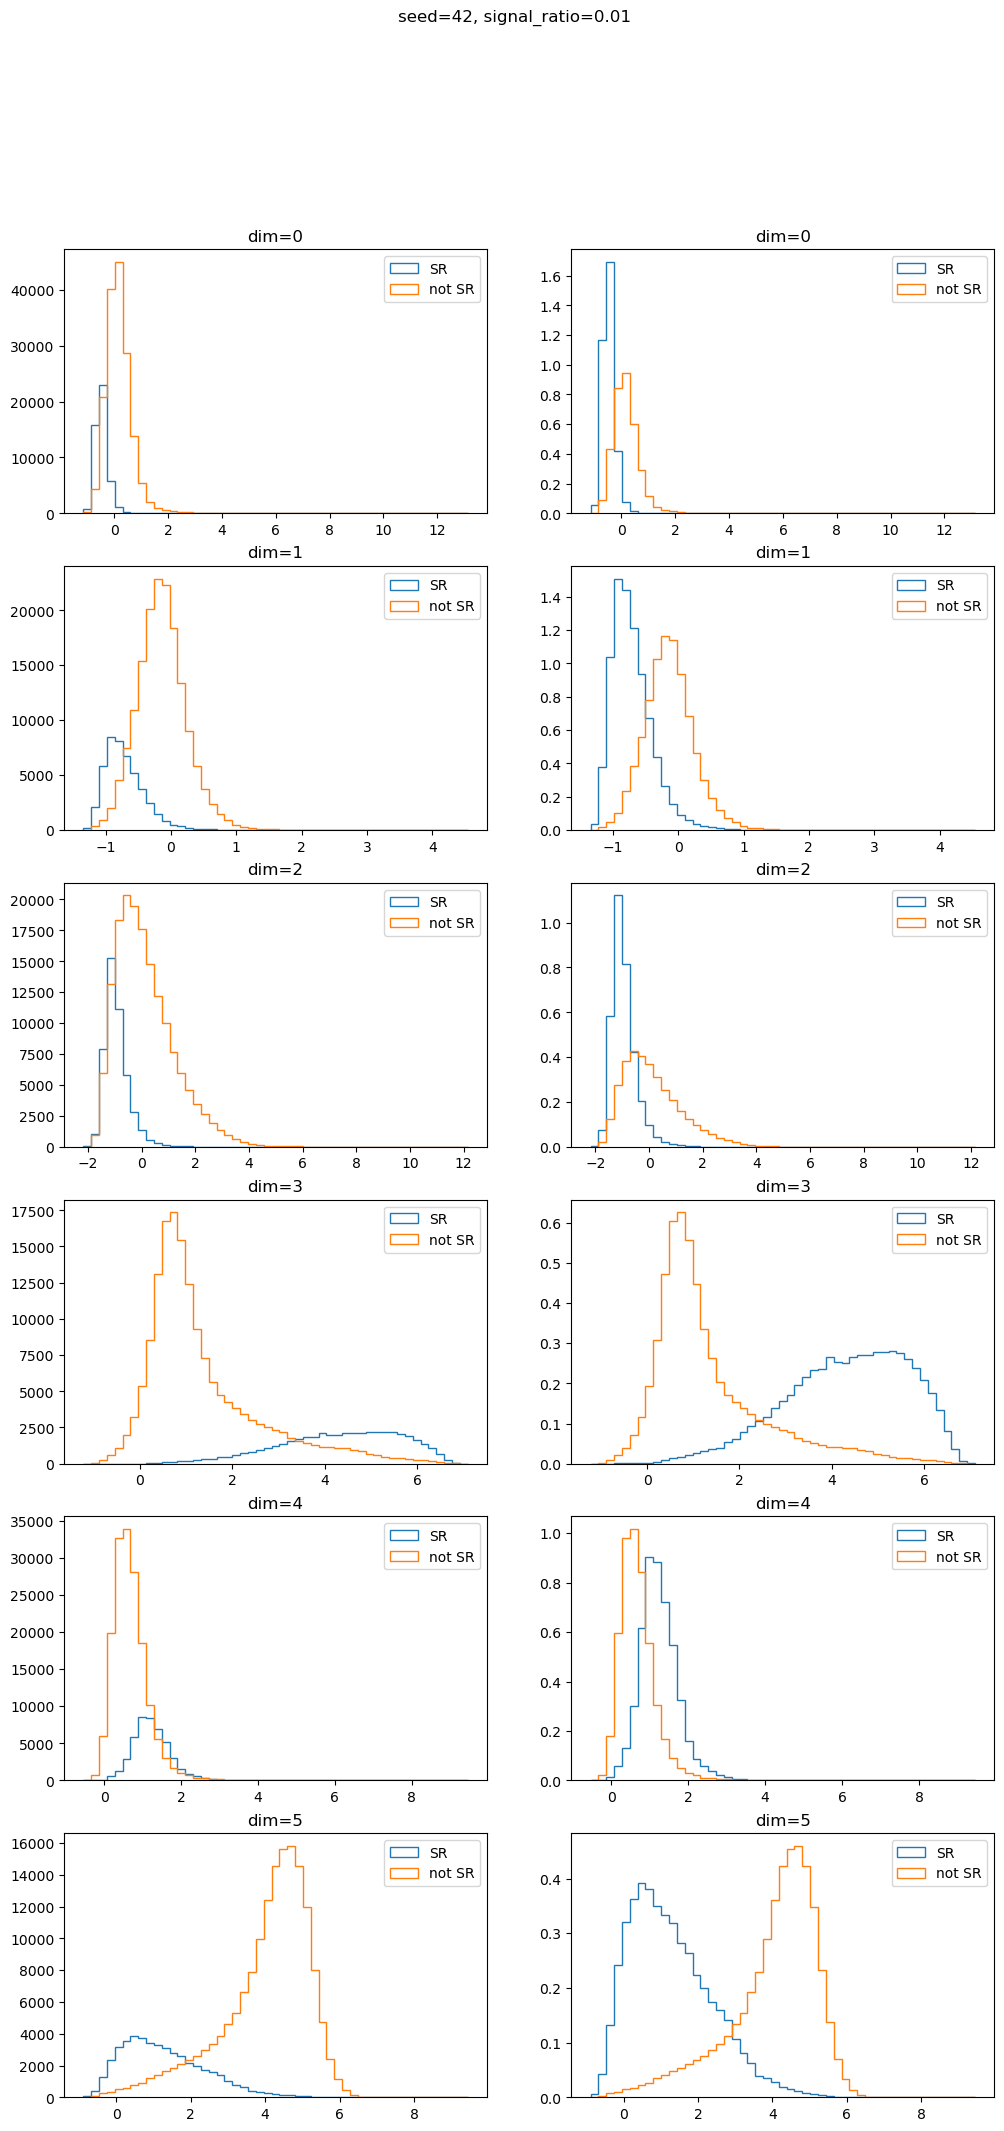

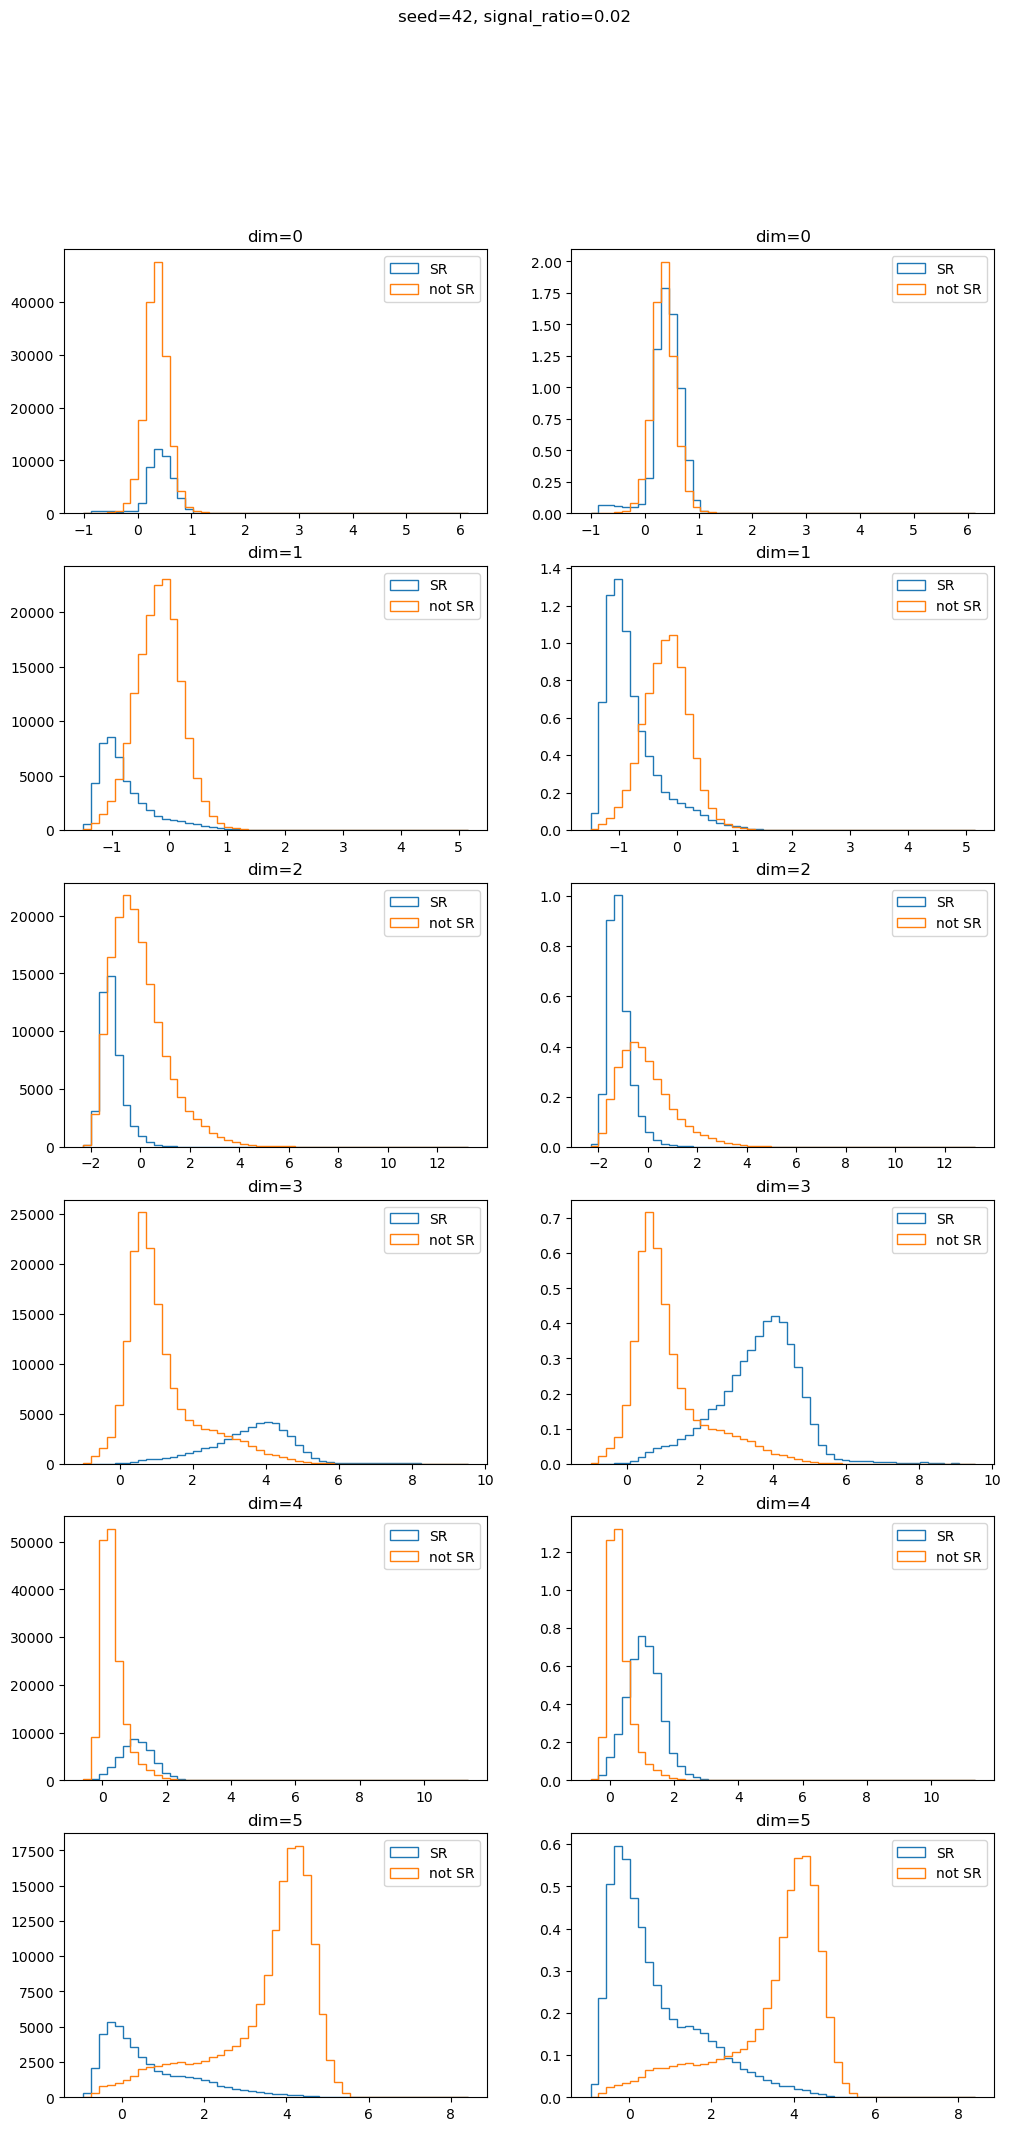

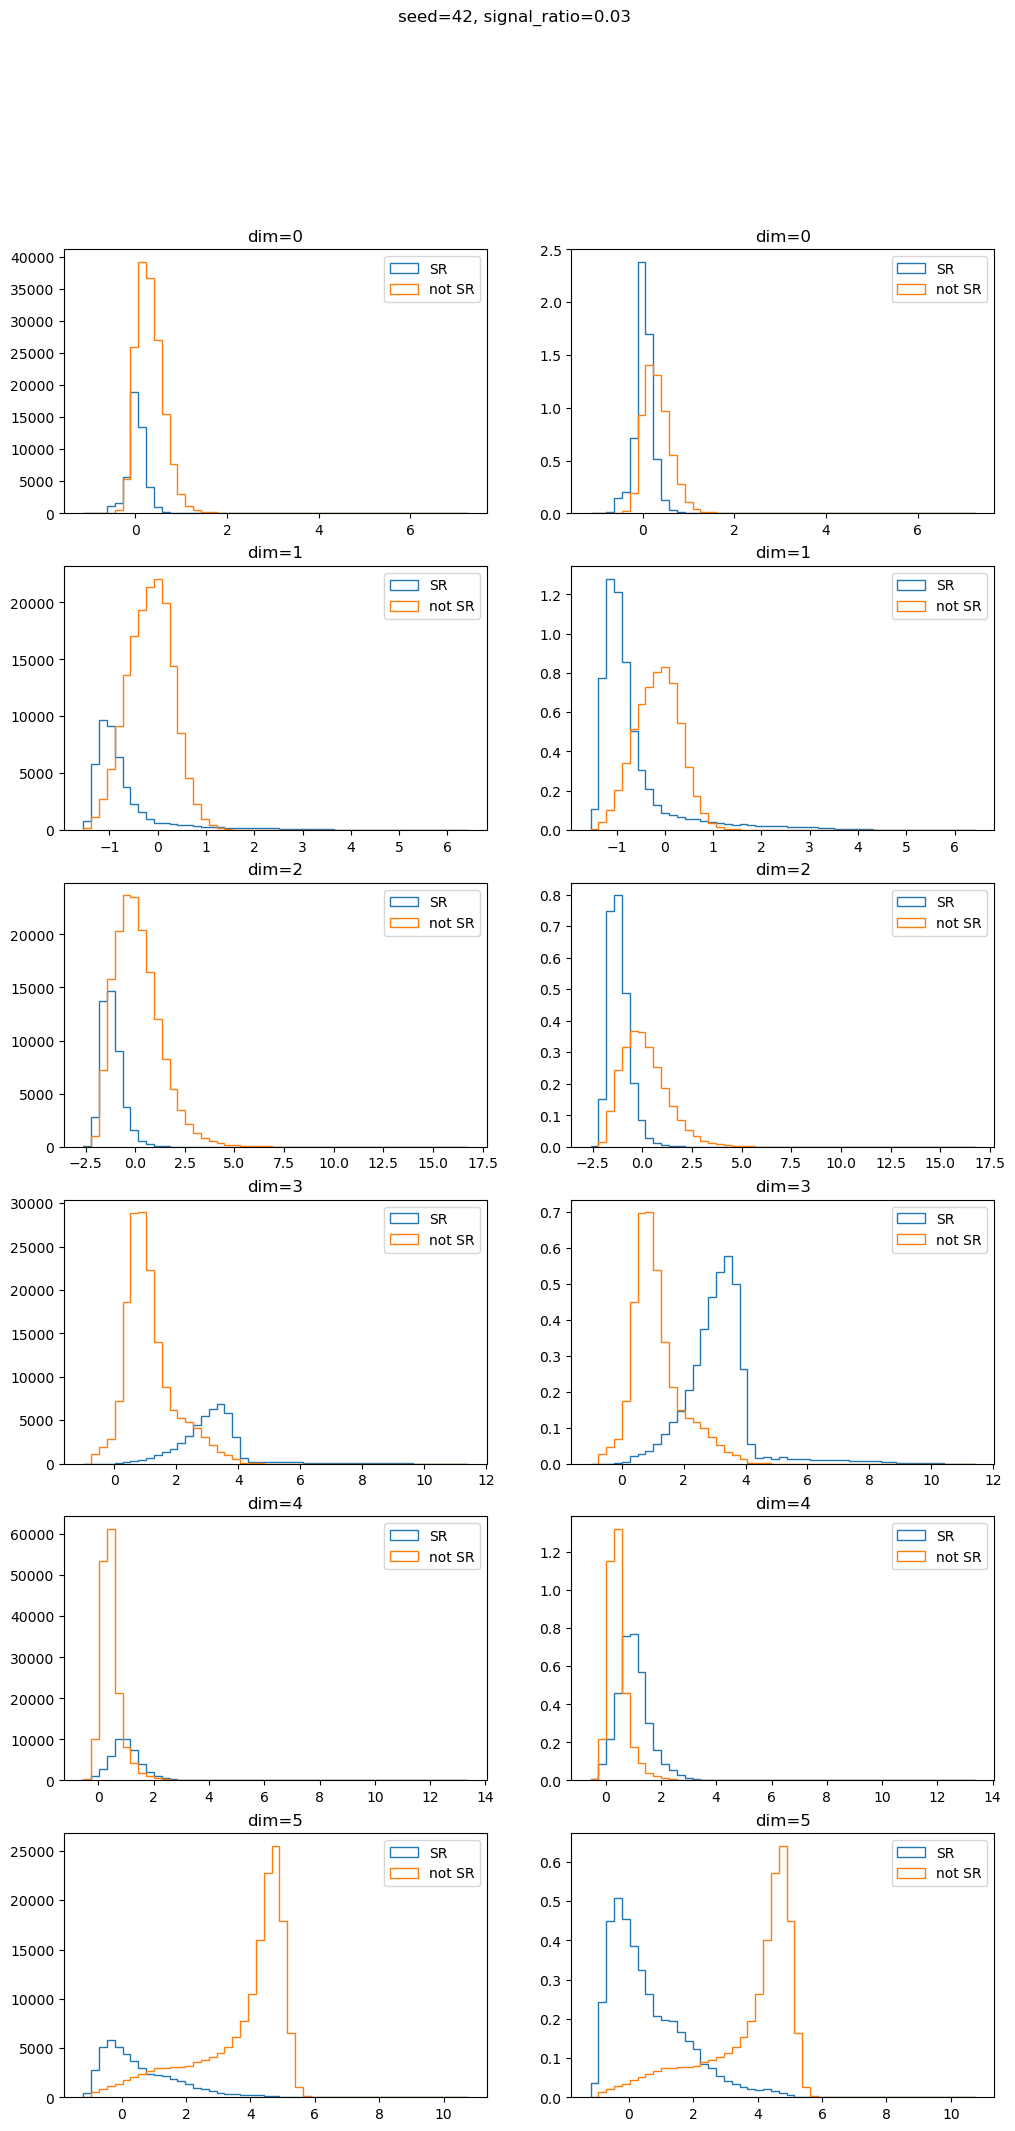

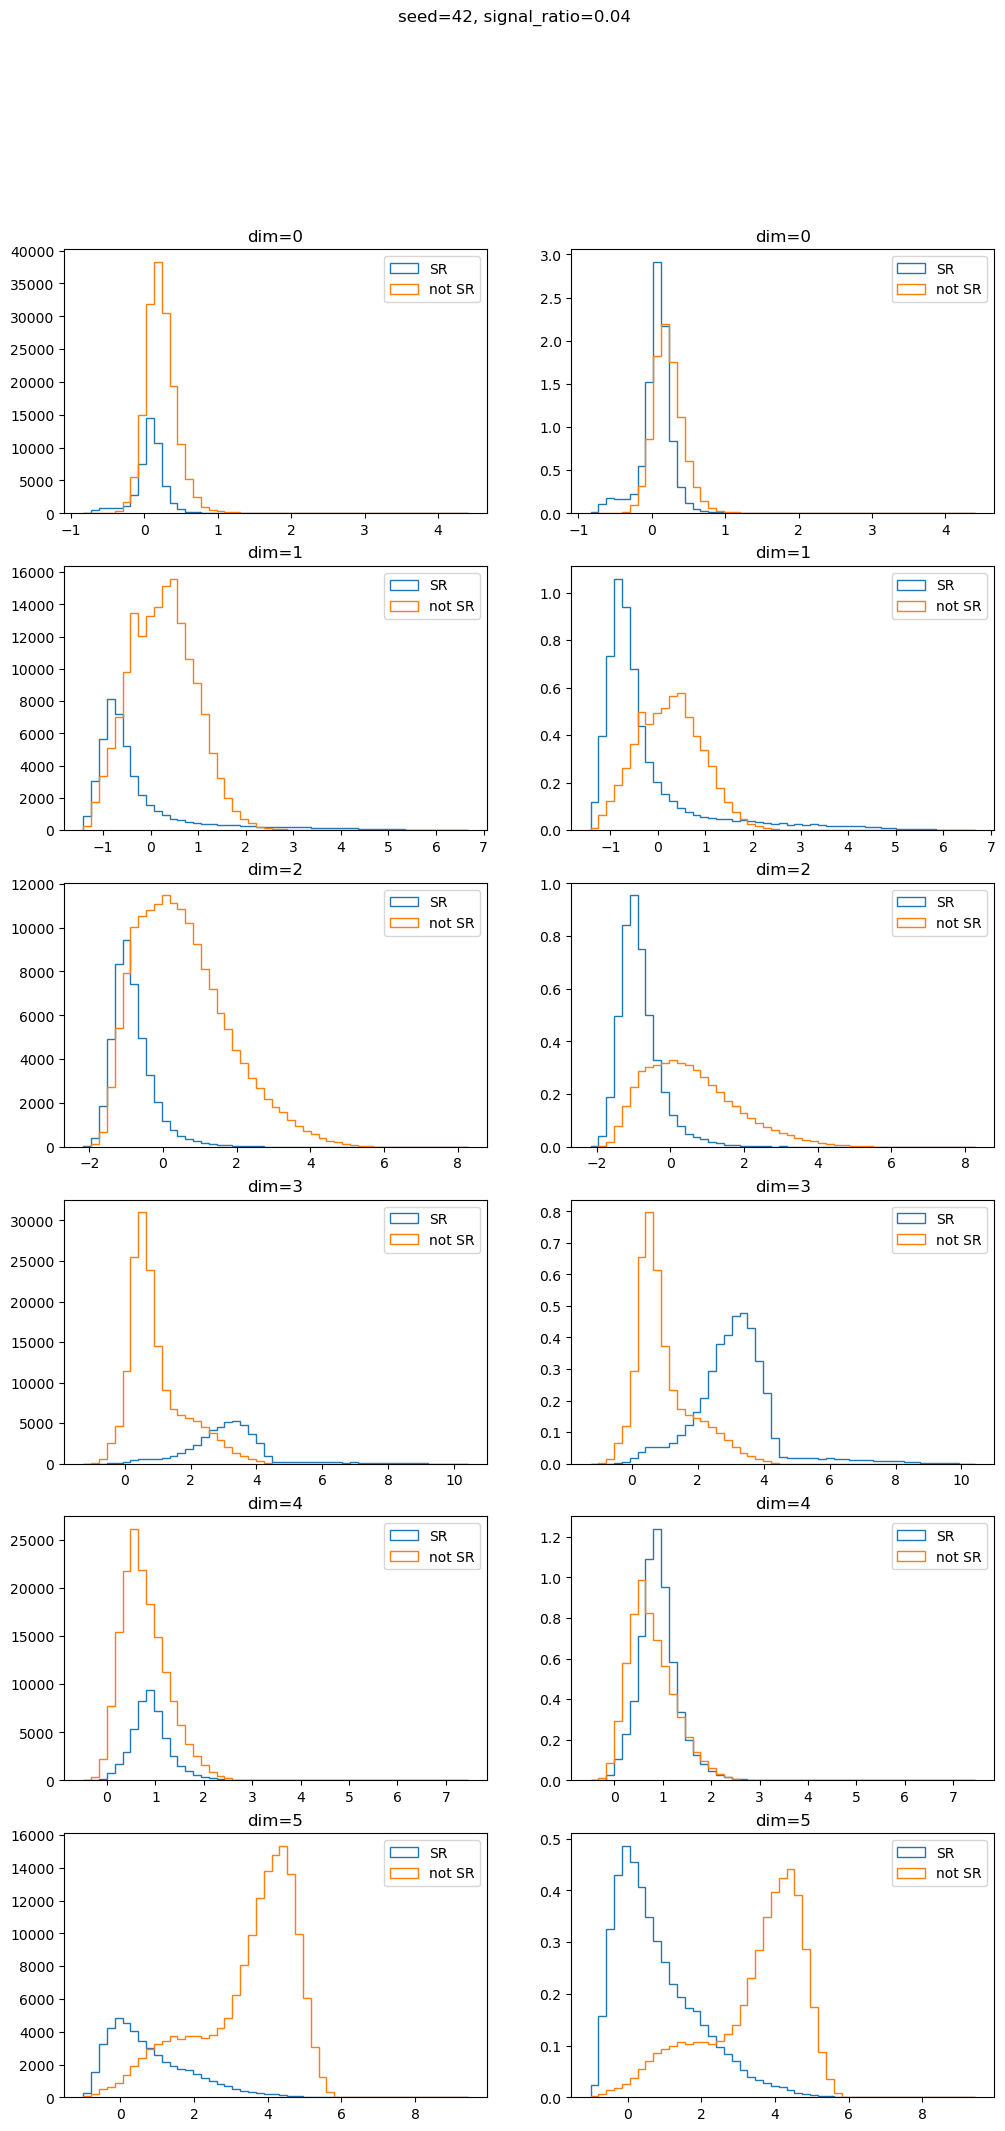

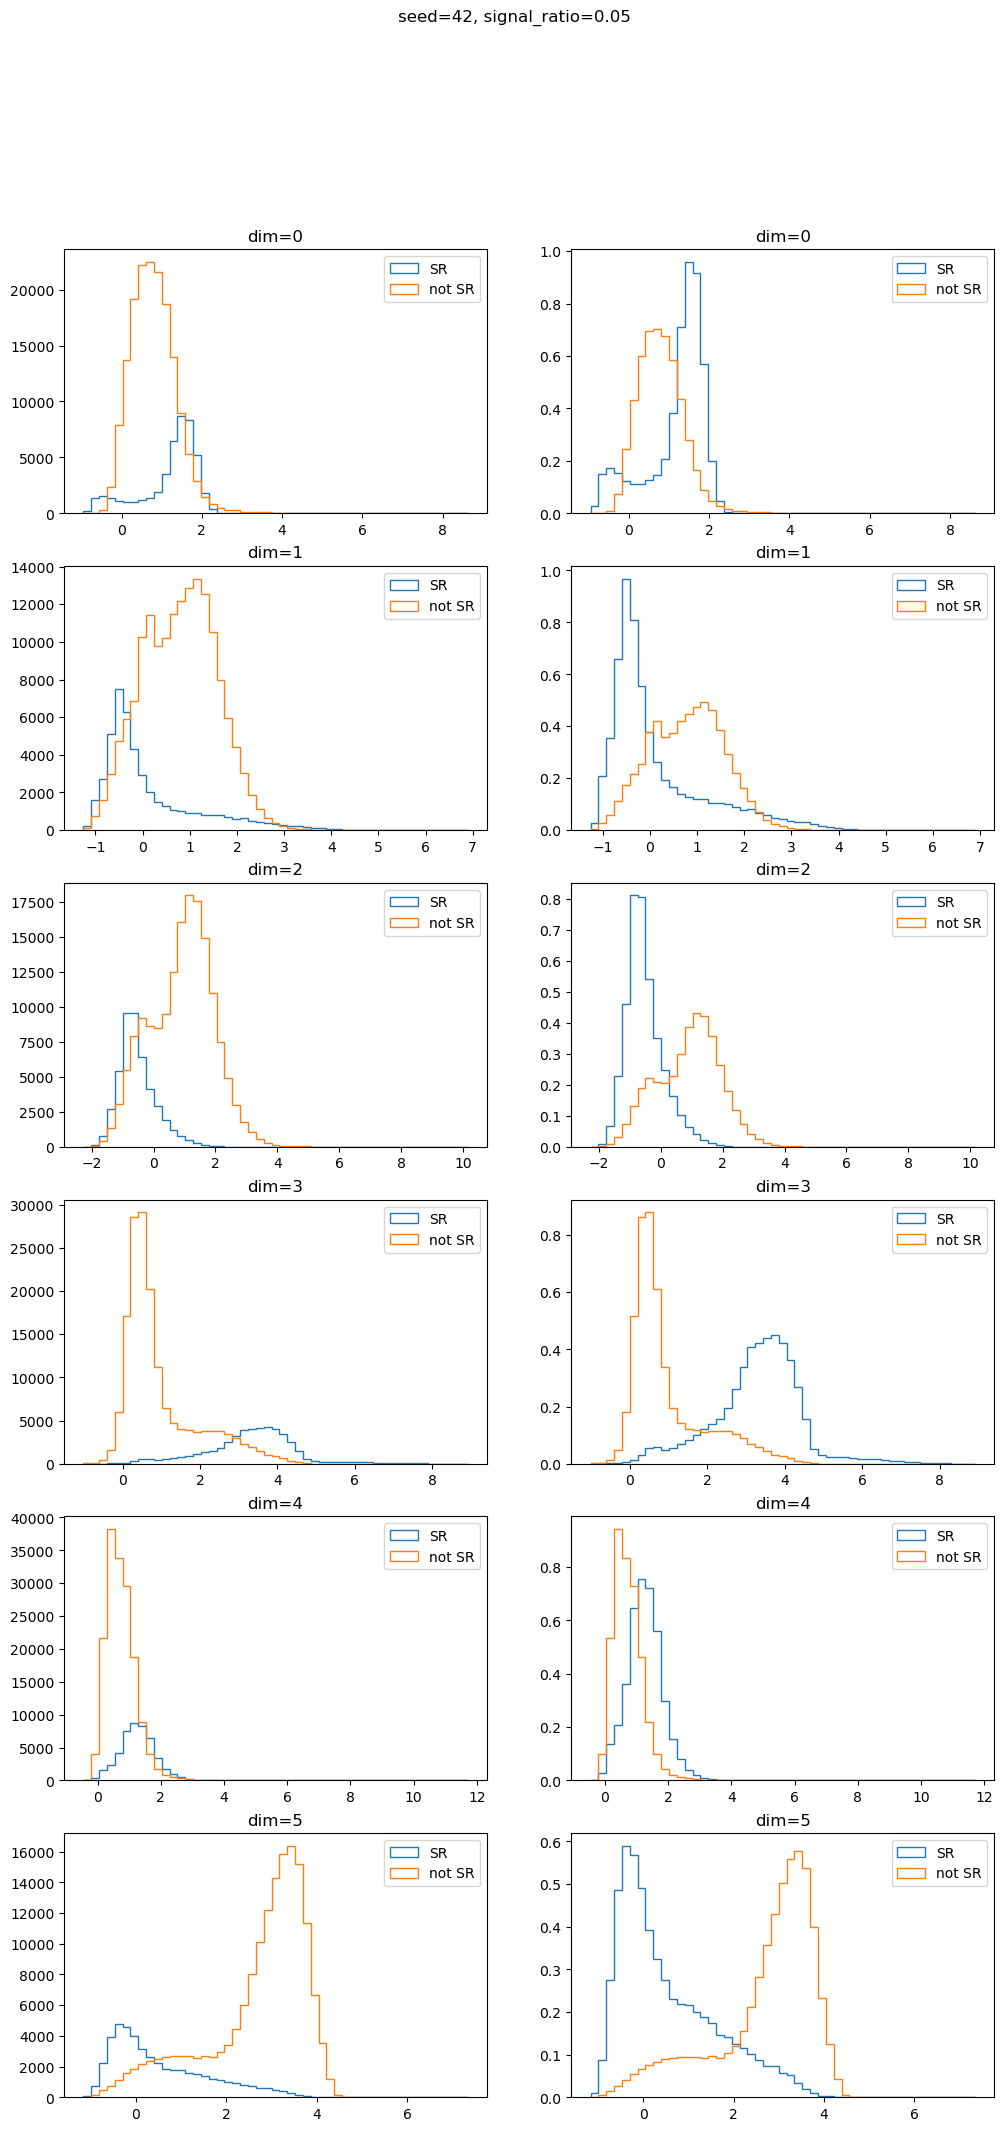

In [25]:
w_cut = 0.2

for seed in seeds:
    for signal_ratio in signal_ratios:
        events = events_test_dict[seed][signal_ratio]
        att_q_repr = att_q_reprs_dict[seed][signal_ratio]
        xgbreg = XGBRegressor(n_estimators=best_n_estimator, max_depth=best_max_depth, random_state=seed)

        X_train = np.concatenate([events.q_repr.reshape(-1, 3 * dim_quadjet_features), 
                                  events.view_score], axis=1)
        xgbreg.fit(X_train, events.is_4b, sample_weight=events.weights)
        probs_4b_estimated = xgbreg.predict(X_train)
        is_in_regions_list = get_regions_via_probs_4b(events, w_cuts, probs_4b_estimated)

        fig, ax = plt.subplots(nrows=dim_quadjet_features, ncols=2, figsize=(12, 4 * dim_quadjet_features))
        fig.suptitle(f"seed={seed}, signal_ratio={signal_ratio}")
        for i in range(dim_quadjet_features):
            bins_range = np.linspace(np.min(att_q_repr[:, i]), np.max(att_q_repr[:, i]), 50)
            for j in range(2):
                density = True if j == 1 else False
                ax[i, j].set_title(f"dim={i}")
                ax[i, j].hist(att_q_repr[is_in_regions_list[int(w_cut * 100)], i], label="SR", 
                              histtype="step", density=density, bins=bins_range)
                ax[i, j].hist(att_q_repr[~is_in_regions_list[int(w_cut * 100)], i], label="not SR", 
                              histtype="step", density=density, bins=bins_range)
                ax[i, j].legend()

        plt.show()